In [1]:
from time import time
t0 = time()
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import itertools as it
from glob import glob

In [28]:
def printtime(message = '', unit = 's'):
    dt = time() - t0
    if unit == 'm':
        dt = dt / 60
    print(message, 'Current time =', round(dt, 1))

def exp_dt(sig):
    """
    expected drift distance  as a function of sigma of the S2 signal (Zrms from kdst 2018 version)
    parameters from the ad-hoc fit
    """
    p = [-10.00667732,  52.1855012,   12.68195726,  58.66322846, -20.11819297]
    dt = p[0] * sig**4 + p[1] * sig**3 + p[2]*sig**2 + p[3]*sig + p[4]
    return dt

In [3]:
def scan_xyz(X, Y, Z, S2e):
    strict_emask = (S2e > strict_ecut[0]) & (S2e < strict_ecut[1])
    
    binEs = np.zeros((len(xybins),len(xybins),len(zbins)))
    binEvts = np.zeros((len(xybins),len(xybins),len(zbins)))
    binStds = np.zeros((len(xybins),len(xybins),len(zbins)))

    tstart = time()
    for (ix, xbin), (iy, ybin), (iz, zbin) in it.product(zip(range(nxy), xybins), zip(range(nxy), xybins), zip(range(nz), zbins)):

        binmask = (X > xbin[0]) & (X < xbin[1]) & (Y > ybin[0]) & (Y < ybin[1]) & (Z > zbin[0]) & (Z < zbin[1])

        if sum(binmask & strict_emask) < 20:
            continue

        S2ecut = S2e[binmask & strict_emask]
        med = np.percentile(S2ecut, 50)
        lo_1s = np.percentile(S2ecut, 50-68/2)
        hi_1s = np.percentile(S2ecut, 50+68/2)
        lo = med - 2.5*(hi_1s - med)
        hi = med + 2.5*(hi_1s - med)

        h = plt.hist(S2ecut, range = (lo, hi), bins = 15)

        xdata = (h[1][:-1] + h[1][1:]) / 2
        ydata = h[0]

        (A0, m0, s0) = (np.max(ydata), np.median(S2ecut), np.std(S2ecut))

        popt, pcov = curve_fit(gauss, xdata, ydata, p0 = (A0, m0, s0))
        fitgauss = gauss(xdata, *popt)
        #plt.plot(xdata, fitgauss)

        (A, m, s) = (popt[0], popt[1], popt[2])
        binEs[ix][iy][iz] = m
        binStds[ix][iy][iz] = s

        flex_emask = (S2e > m - 3.5 * s) & (S2e < m + 3.5 * s)    
        binEvts[ix][iy][iz] = sum(binmask & flex_emask)

        plt.close()

        #plt.title('X = '+str(xbin)+'; Y = '+str(ybin)+'; Z ='+str(zbin))
        #plt.show()
    print('E determination time =', round((time() - tstart)/60, 2))
    
    return binEs, binEvts, binStds

In [4]:
runno = '7479'

In [5]:
def ndigit(j, n):
    j = str(j)
    while len(j) < n:
        j = '0' + j
    return j

In [7]:
kdstdir = '/Volumes/NEXT_data/IC_Data/kdst/'+runno+'/*'
all_kdst_filenames = glob(kdstdir)

In [8]:
all_kdst_filenames[0]

'/Volumes/NEXT_data/IC_Data/kdst/7479/kdst_0000_7479_trigger1_v1.1.0_20190801_autotrigger.h5'

In [9]:
# kdst_filename = all_kdst_filenames[0]
# kdst_filename2 = all_kdst_filenames[1]

allkdst = None
tstart = time()
tcurrent = tstart
for kdst_filename in all_kdst_filenames:
    kdst = pd.HDFStore(kdst_filename, 'r')['DST/Events']
    if time() - tcurrent > 30:
        print('Working on', kdst_filename)
        tcurrent = time()
    if allkdst is None:
        allkdst = kdst
    else:
        allkdst = allkdst.append(kdst)

print("Current time =", round((time() - t0)/60,1))
# kdst = pd.HDFStore(kdst_filename, 'r')['DST/Events']
# kdst2 = pd.HDFStore(kdst_filename2, 'r')['DST/Events']

Working on /Volumes/NEXT_data/IC_Data/kdst/7479/kdst_0441_7479_trigger1_v1.1.0_20190801_autotrigger.h5
Working on /Volumes/NEXT_data/IC_Data/kdst/7479/kdst_0751_7479_trigger1_v1.1.0_20190801_autotrigger.h5
Working on /Volumes/NEXT_data/IC_Data/kdst/7479/kdst_1007_7479_trigger1_v1.1.0_20190801_autotrigger.h5
Working on /Volumes/NEXT_data/IC_Data/kdst/7479/kdst_1235_7479_trigger1_v1.1.0_20190801_autotrigger.h5
Working on /Volumes/NEXT_data/IC_Data/kdst/7479/kdst_1463_7479_trigger1_v1.1.0_20190801_autotrigger.h5
Working on /Volumes/NEXT_data/IC_Data/kdst/7479/kdst_1667_7479_trigger1_v1.1.0_20190801_autotrigger.h5
Working on /Volumes/NEXT_data/IC_Data/kdst/7479/kdst_1878_7479_trigger1_v1.1.0_20190801_autotrigger.h5
Current time = 4.1


In [10]:
allkdst.keys()

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [11]:
from scipy.optimize import curve_fit

def gauss(x, A, m, s):
    if s < 0:
        return 10000000000000000
    return A*np.exp(-(x-m)**2 / (2*s**2))

In [12]:
nxy = 9+1
nz = 5+1

binedges = np.linspace(-200, 200, nxy)
xybins = np.array((binedges[:-1], binedges[1:])).T

zbinedges = np.linspace(0, 500, nz)
zbins = np.array((zbinedges[:-1], zbinedges[1:])).T

print('xybins =', xybins)
print('zbins =', zbins)

strict_ecut = (1000, 16000)

xybins = [[-200.         -155.55555556]
 [-155.55555556 -111.11111111]
 [-111.11111111  -66.66666667]
 [ -66.66666667  -22.22222222]
 [ -22.22222222   22.22222222]
 [  22.22222222   66.66666667]
 [  66.66666667  111.11111111]
 [ 111.11111111  155.55555556]
 [ 155.55555556  200.        ]]
zbins = [[  0. 100.]
 [100. 200.]
 [200. 300.]
 [300. 400.]
 [400. 500.]]


In [34]:
kS2e = np.array(allkdst.S2e)
kX = np.array(allkdst.X)
kY = np.array(allkdst.Y)
kZ = exp_dt(np.array(allkdst.Zrms))

print('Before cut:',len(kX))

r2mask = (kX**2 + kY**2) < 160**2
loose_ecut = (500, 25000)
loose_emask = (kS2e > loose_ecut[0]) & (kS2e < loose_ecut[1])
kdst_cut = r2mask & loose_emask

kS2e = kS2e[kdst_cut]
kX = kX[kdst_cut]
kY = kY[kdst_cut]
kZ = kZ[kdst_cut]

print('After cut:',len(kX))

Before cut: 215859
After cut: 101491


In [14]:
kbinEs, kbinEvts, kbinStds = scan_xyz(kX, kY, kZ, kS2e)

E determination time = 3.68


In [15]:
printtime()

 Current time = 466.1


In [16]:
import json

jsonfile = '/Volumes/NEXT_data/IC_Data/krThesis/sliding_window_events/meshed_outputs_20210222/meshed_output_allfiles_7479_d210217_multiple_events_buffer_20210219.json'
f = open(jsonfile)
histat_data = json.load(f)
f.close()

In [17]:
histat_data.keys()

dict_keys(['events_energy', 'events_prewindow_sums', 'all_Zgauss', 'all_Wgauss', 'all_Zrms', 'all_Wrms', 'events_X_sipm_subtracted', 'events_Y_sipm_subtracted', 'events_localit_X', 'events_localit_Y', 'events_local_X', 'events_local_Y', 'events_global_X', 'events_global_Y', 'ring_events_sipm_aroundevt', 'ring_events_sipm_aroundevt_noctr', 'all_R2', 'events_postwindow_sums', 'all_sres', 'all_ssres', 'all_cutoff', 'event_time_bounds', 'events_energy_ideal_window', 'events_prewindow_sums_ideal_window_rescaled', 'events_energy_ideal_window_subtracted'])

In [35]:
jS2e = np.array(histat_data['events_energy_ideal_window']) - (16.0/25.0) * np.array(histat_data['events_prewindow_sums'])
jX = np.array(histat_data['events_localit_X'])
jY = np.array(histat_data['events_localit_Y'])
jZ = np.array(histat_data['all_Zrms'])

print('Before cut:',len(jX))

r2mask = (jX**2 + jY**2) < 160**2
loose_emask = (jS2e > loose_ecut[0]) & (jS2e < loose_ecut[1])
json_cut = r2mask & loose_emask

jS2e = jS2e[json_cut]
jX = jX[json_cut]
jY = jY[json_cut]
jZ = jZ[json_cut]

print('After cut:',len(jX))

Before cut: 1031483
After cut: 98822


In [19]:
jbinEs, jbinEvts, jbinStds = scan_xyz(jX, jY, jZ, jS2e)

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


E determination time = 3.76


In [20]:
selX = int(len(xybins) / 2)
selY = selX

zstarts = [zbin[0] for zbin in zbins]

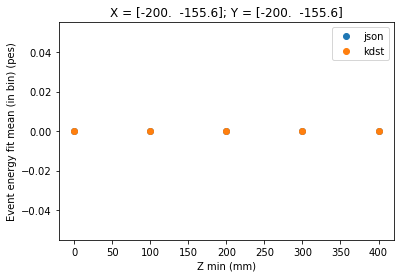

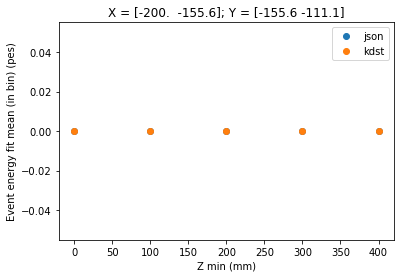

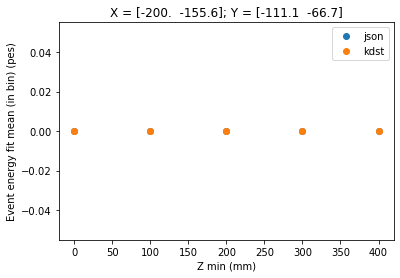

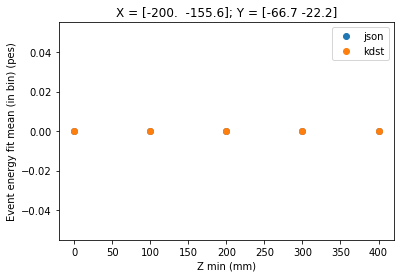

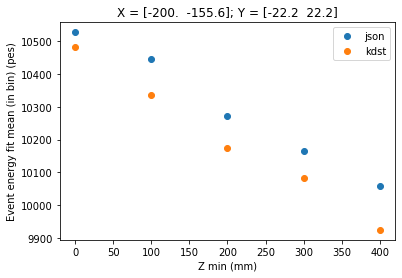

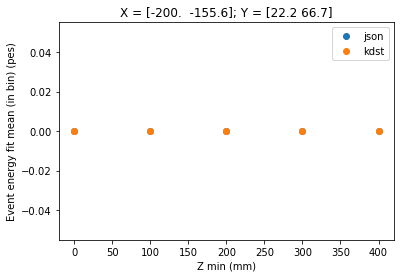

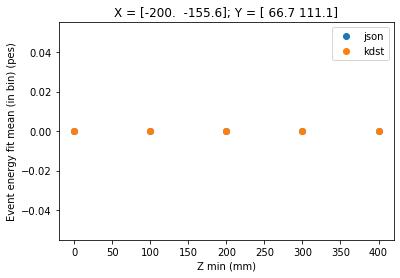

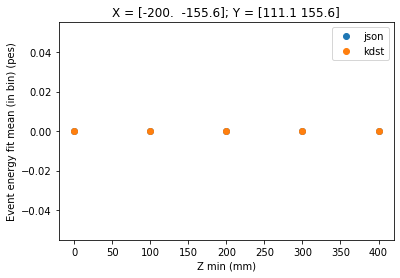

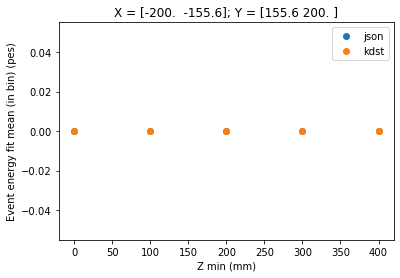

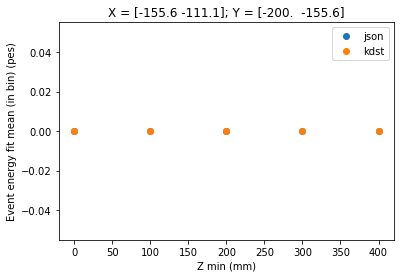

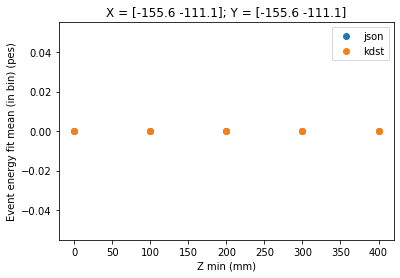

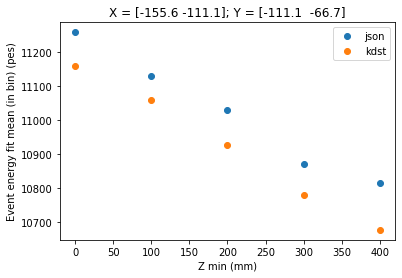

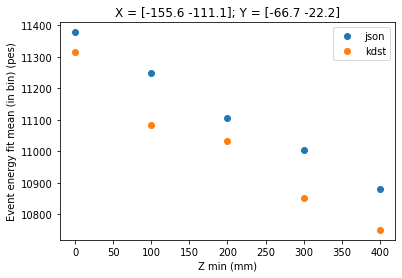

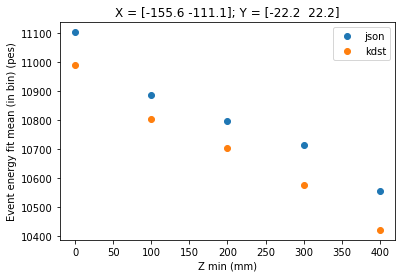

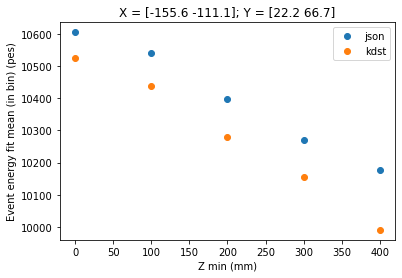

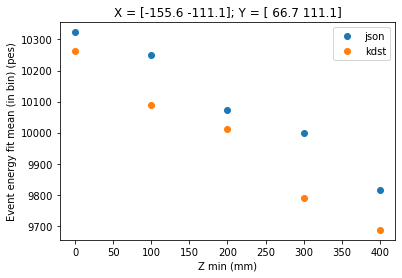

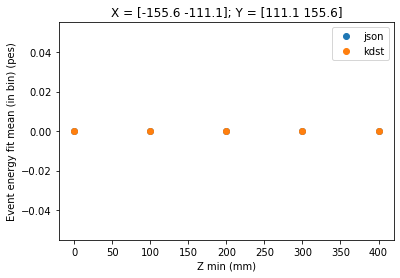

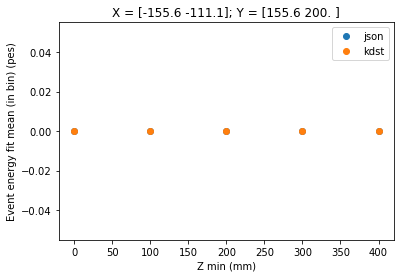

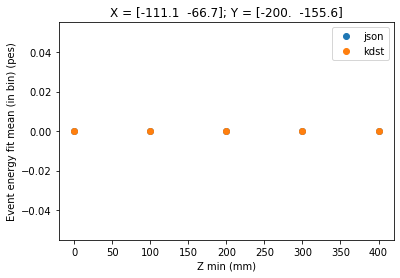

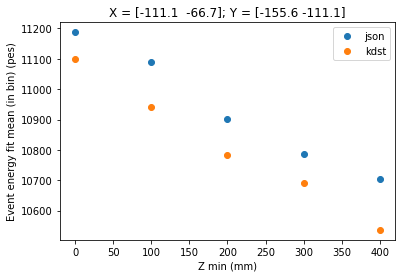

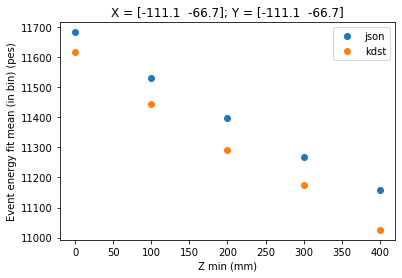

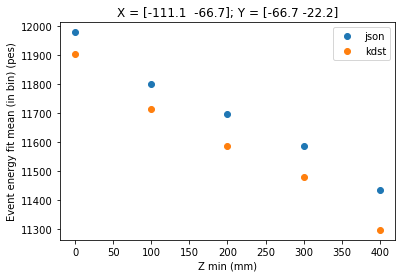

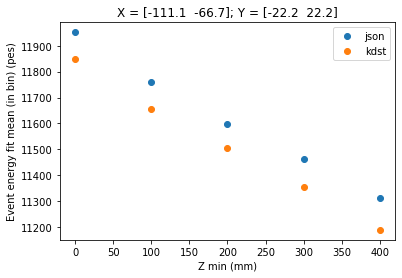

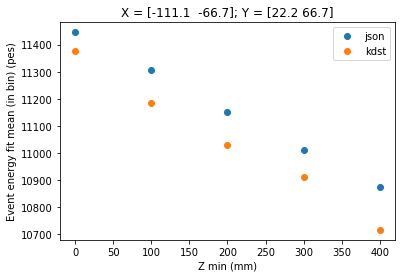

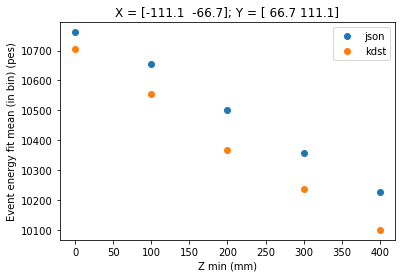

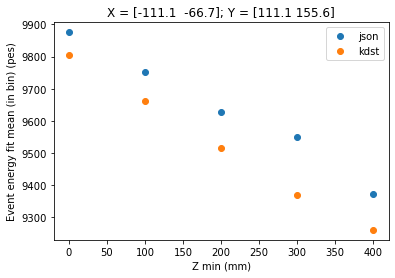

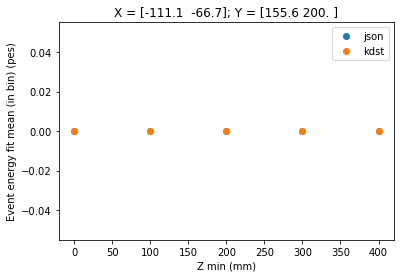

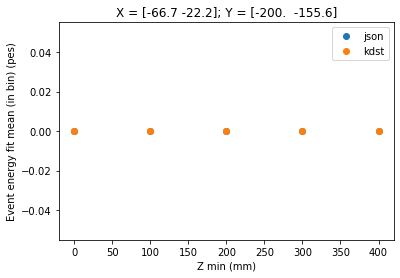

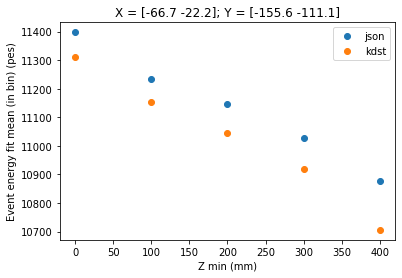

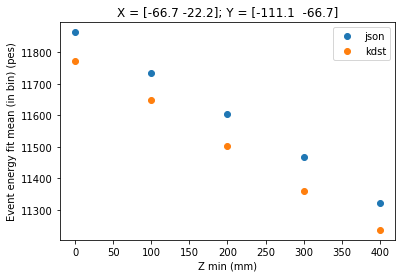

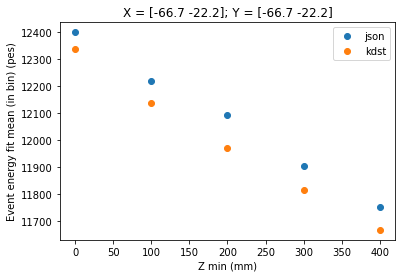

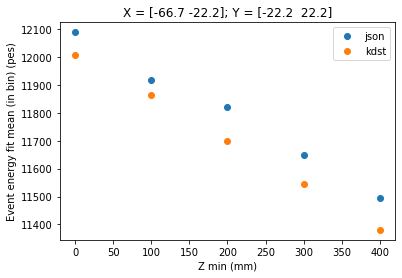

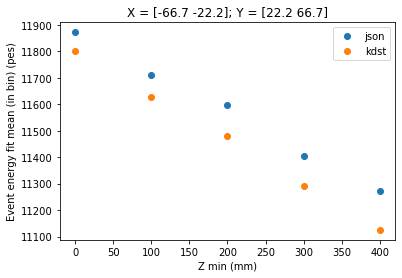

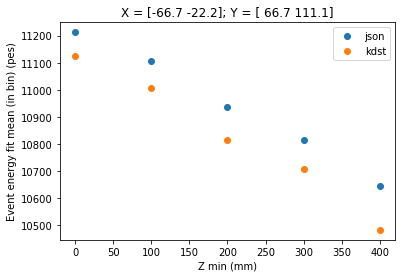

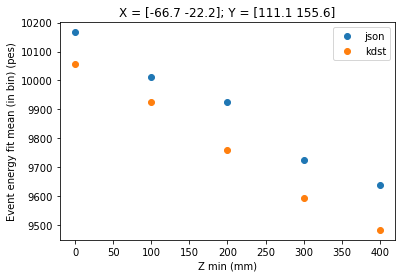

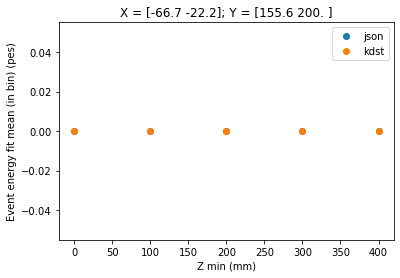

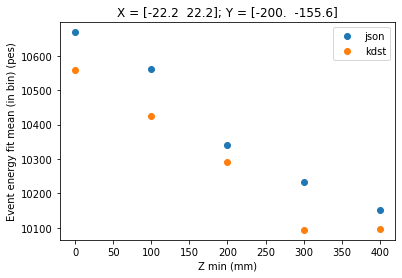

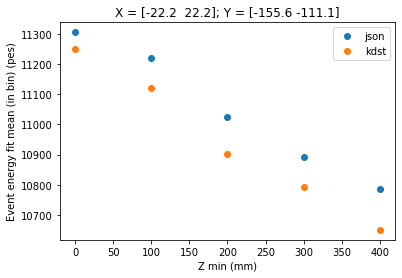

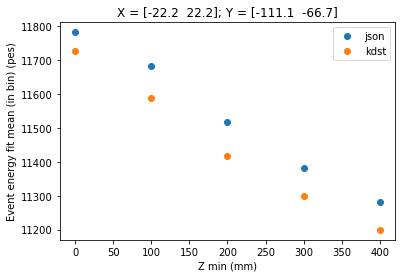

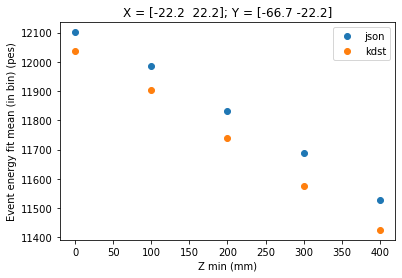

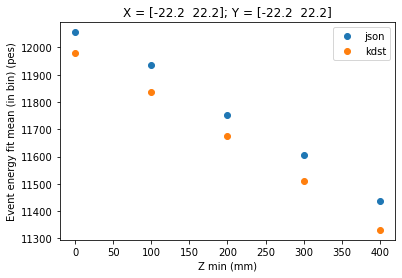

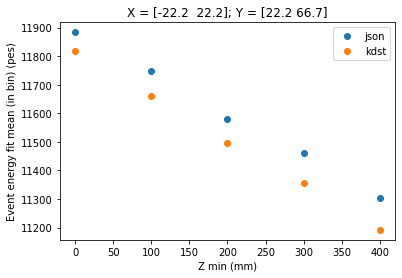

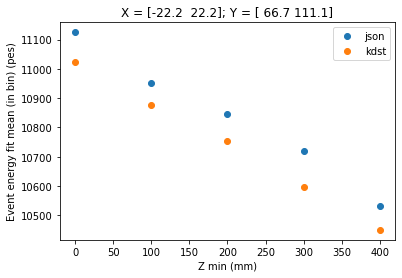

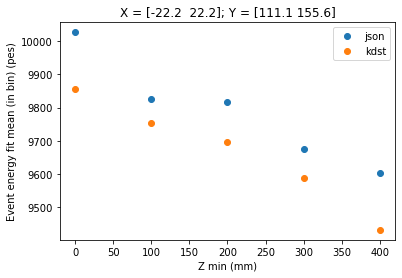

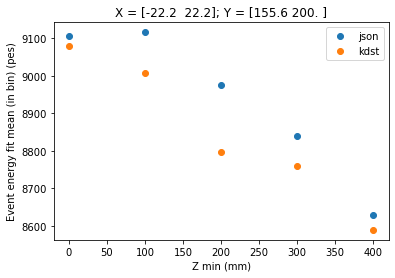

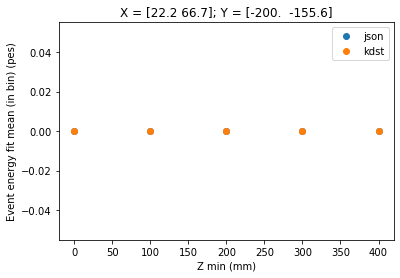

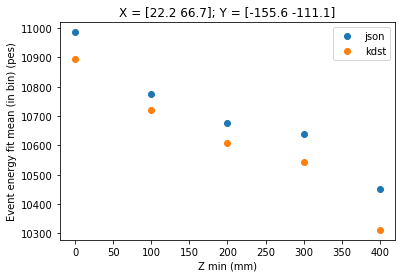

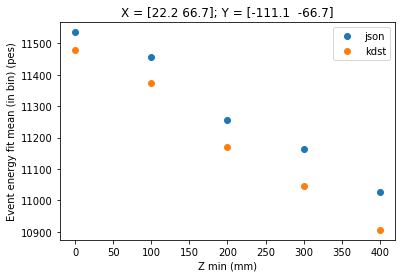

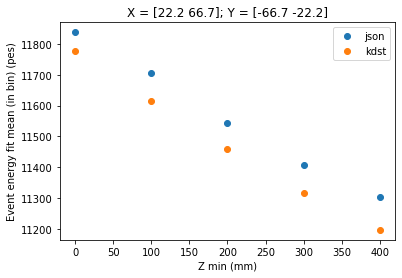

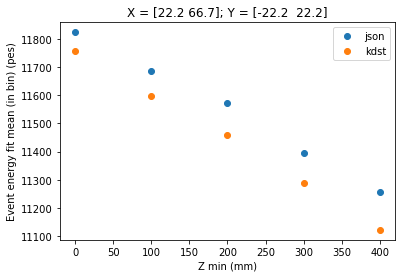

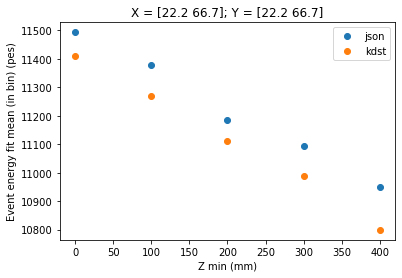

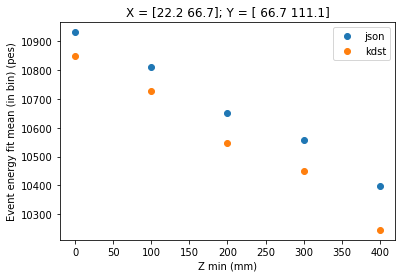

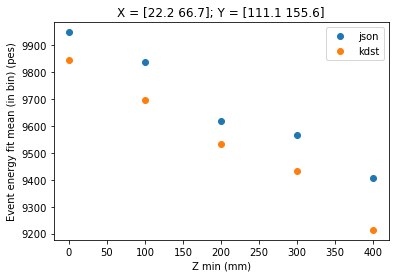

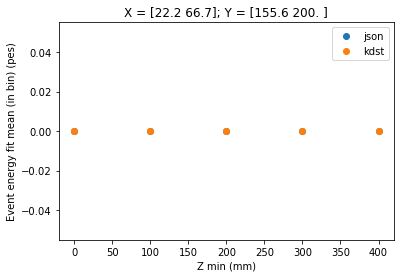

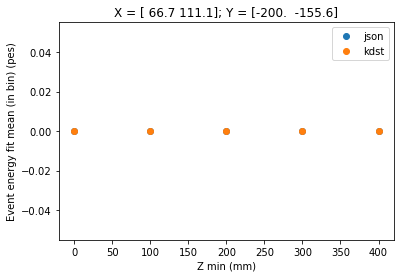

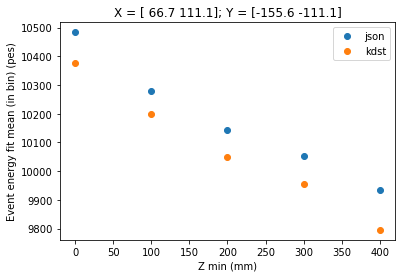

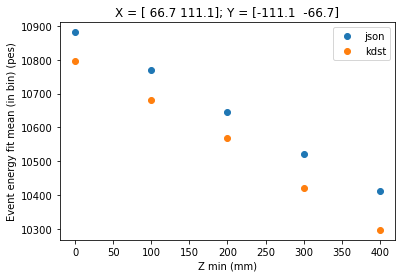

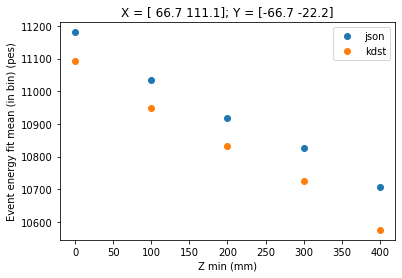

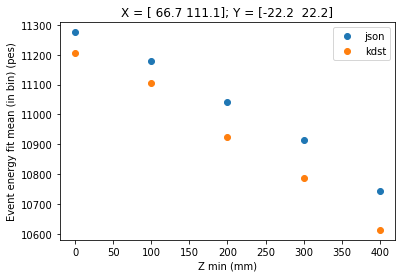

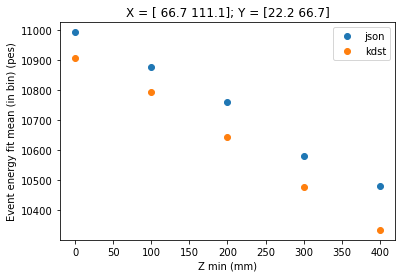

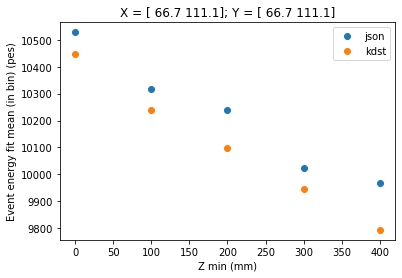

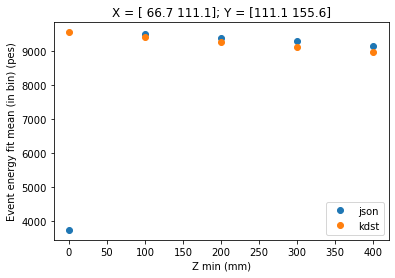

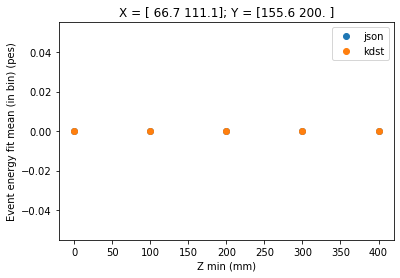

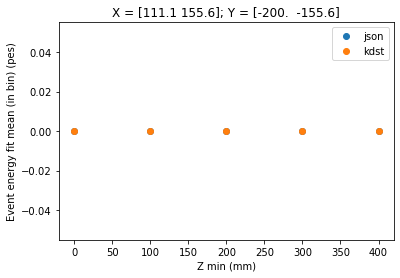

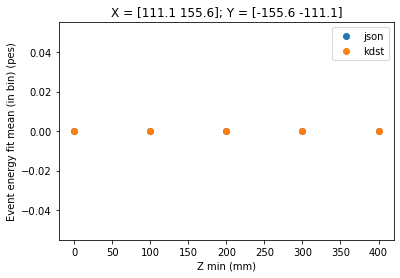

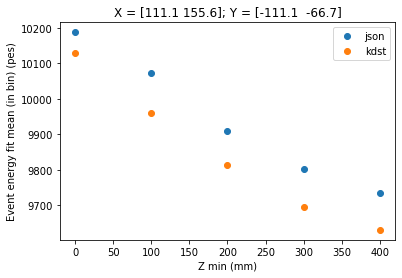

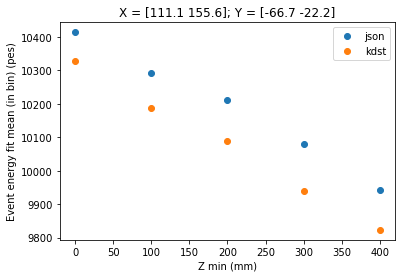

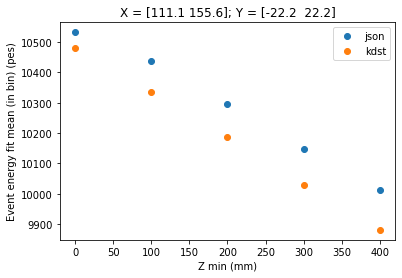

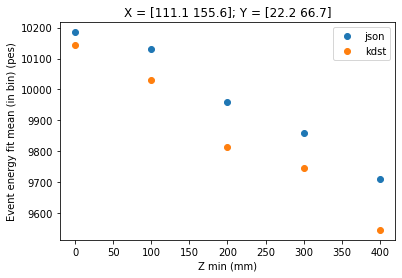

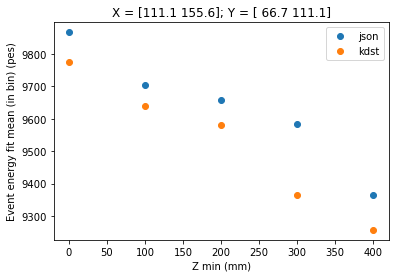

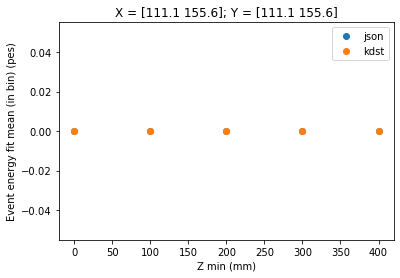

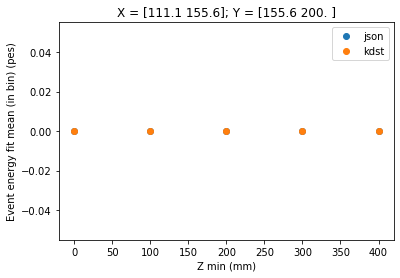

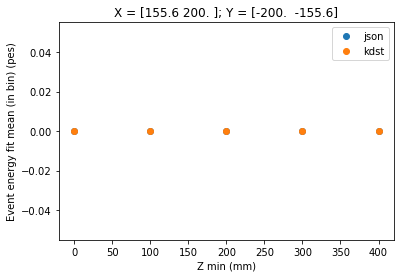

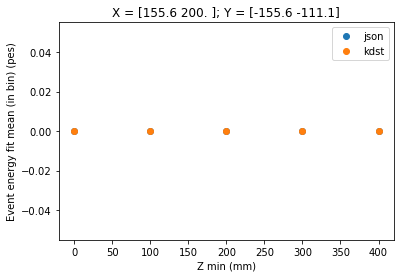

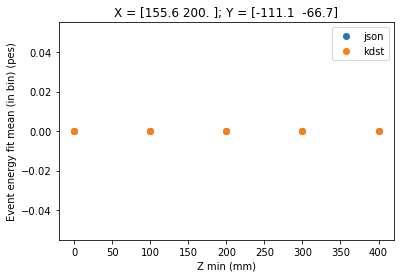

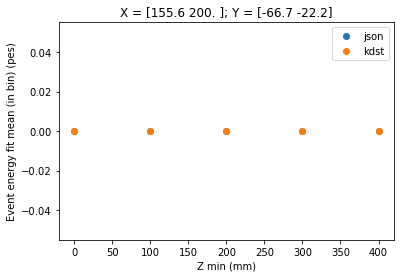

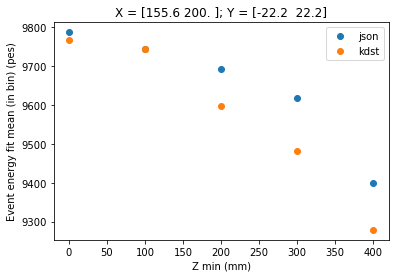

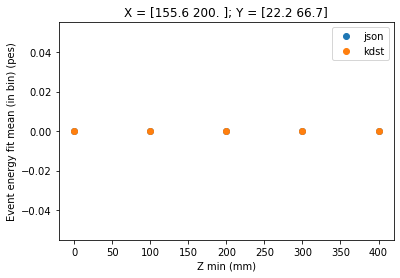

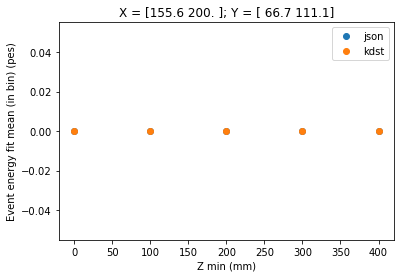

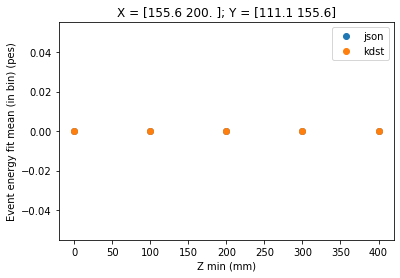

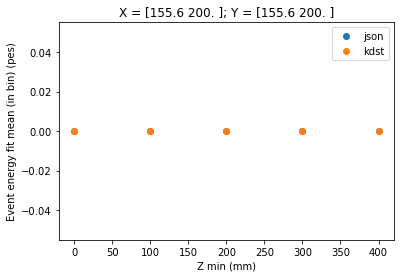

In [21]:
for selX, selY in it.product(range(nxy-1), range(nxy-1)):
    xbinname = str(np.round(xybins[selX],1))
    ybinname = str(np.round(xybins[selY],1))
    plt.plot(zstarts, jbinEs[selX][selY], 'o', label='json')
    plt.plot(zstarts, kbinEs[selX][selY], 'o', label='kdst')
    plt.title('X = '+xbinname+'; Y = '+ybinname)
    plt.xlabel('Z min (mm)')
    plt.ylabel('Event energy fit mean (in bin) (pes)')
    plt.legend()
    plt.show()

In [22]:
printtime()

 Current time = 735.1


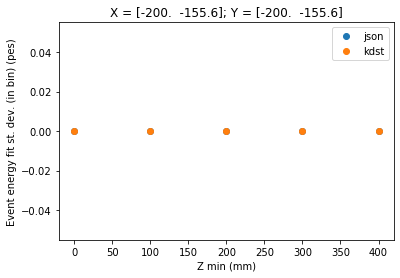

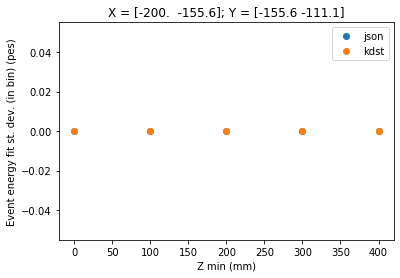

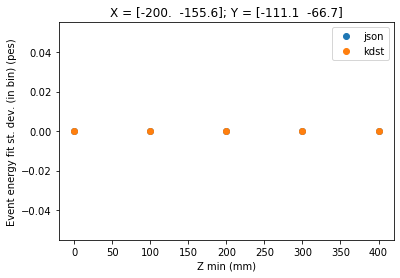

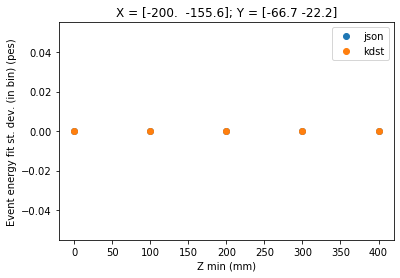

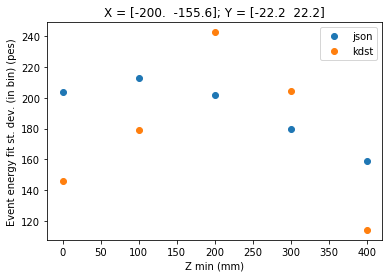

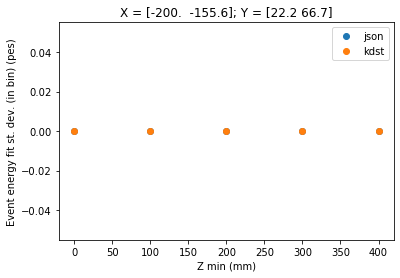

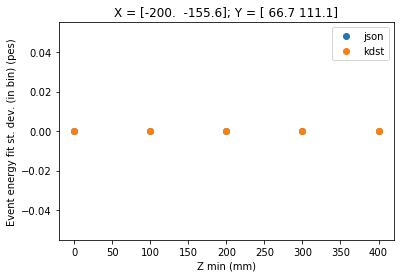

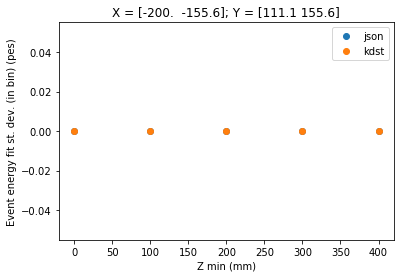

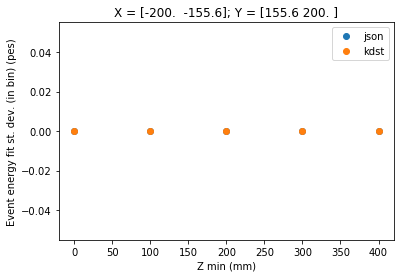

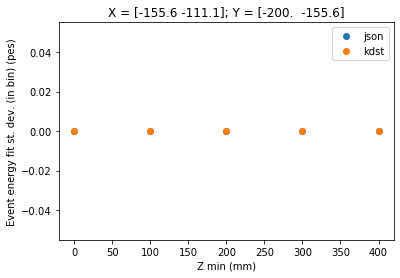

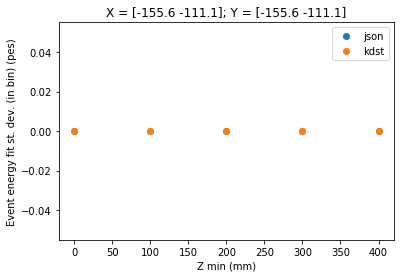

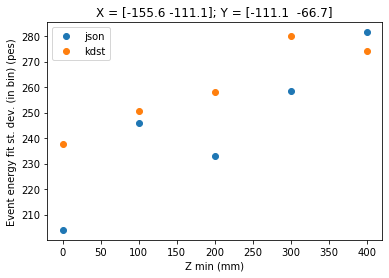

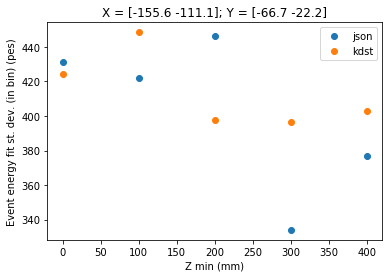

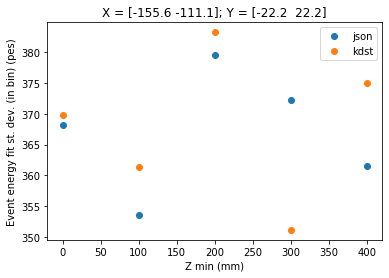

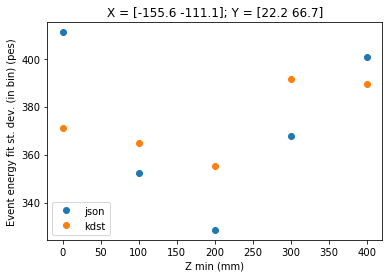

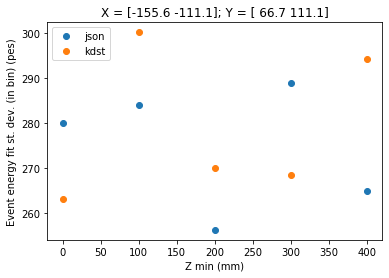

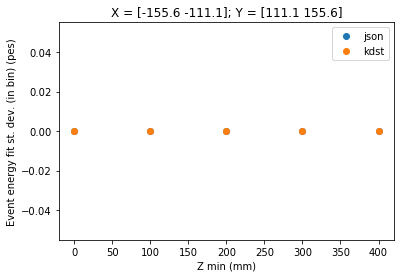

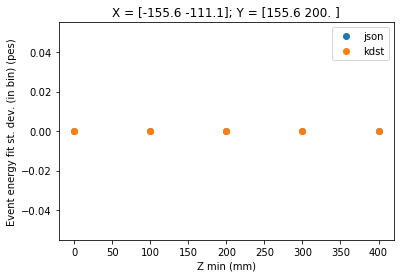

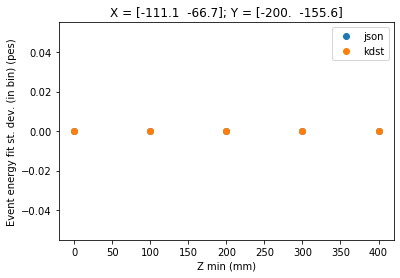

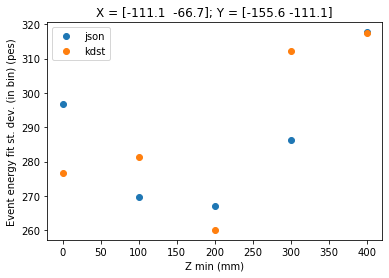

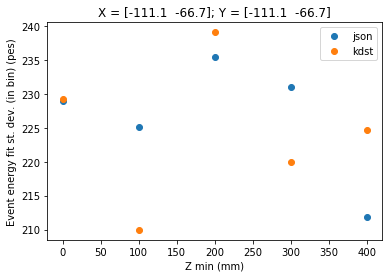

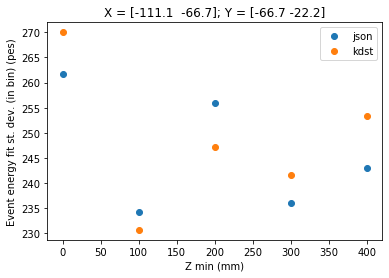

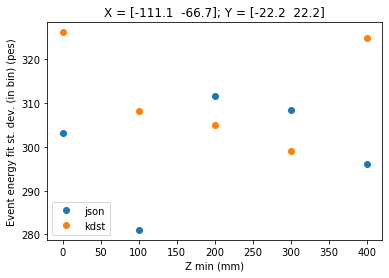

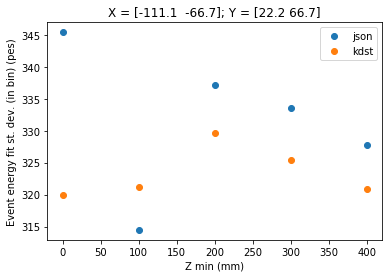

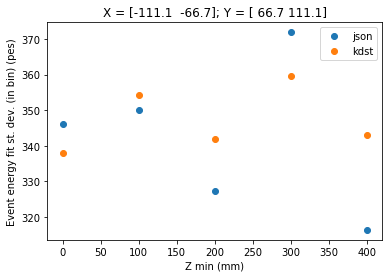

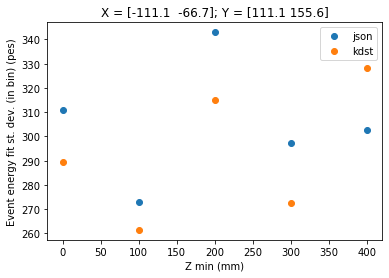

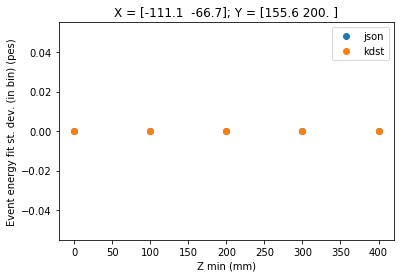

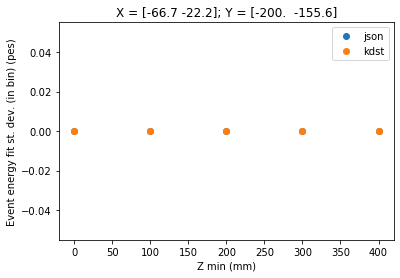

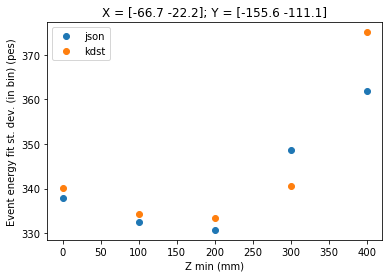

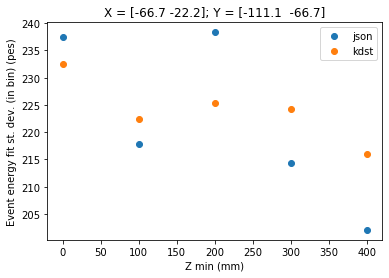

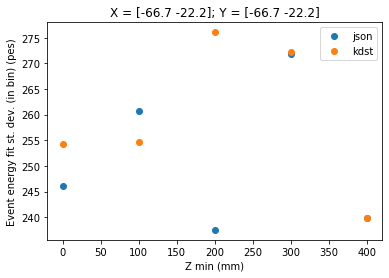

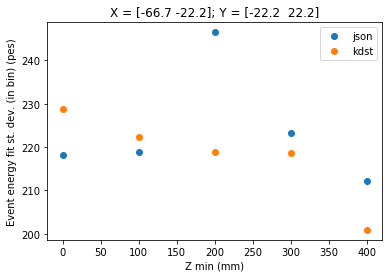

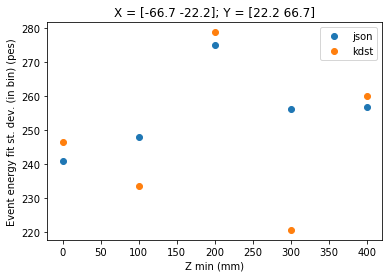

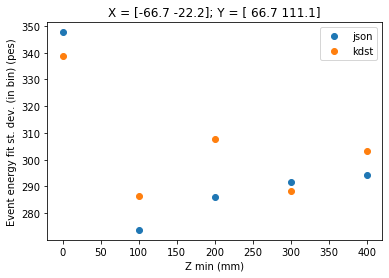

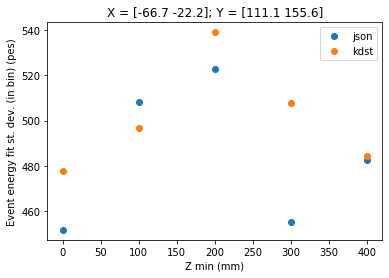

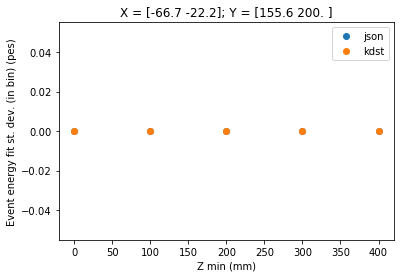

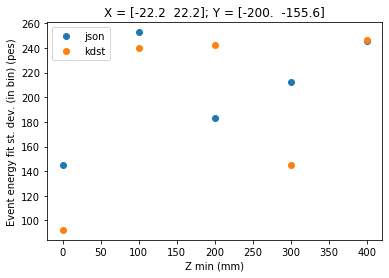

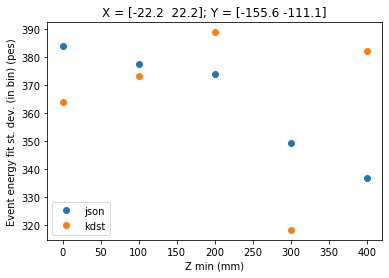

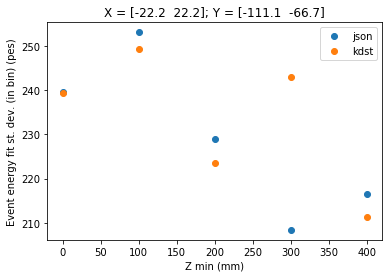

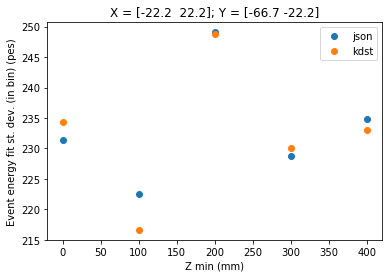

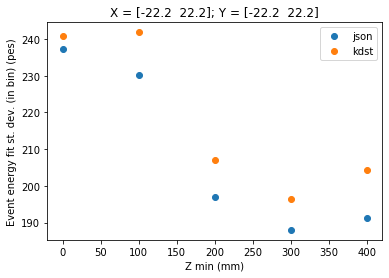

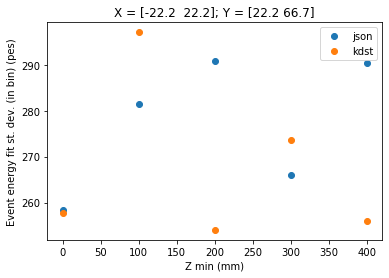

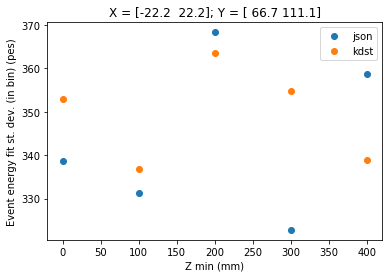

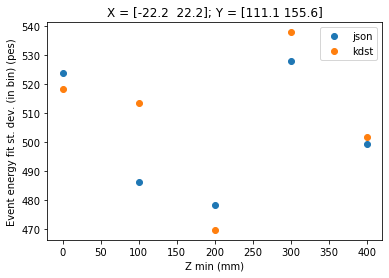

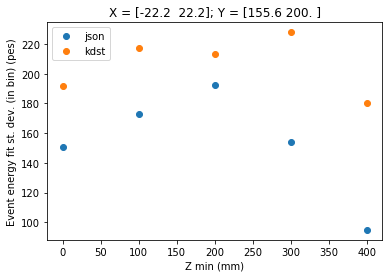

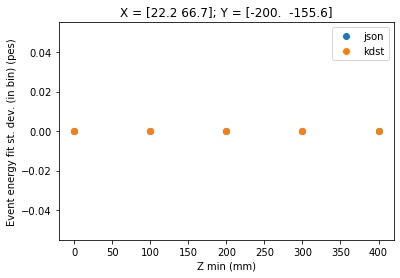

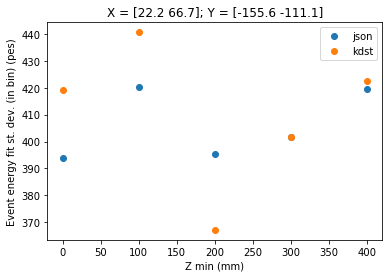

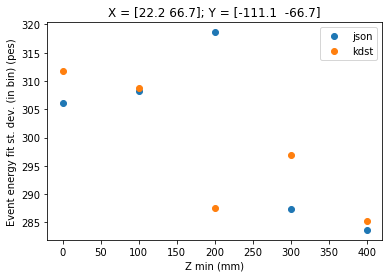

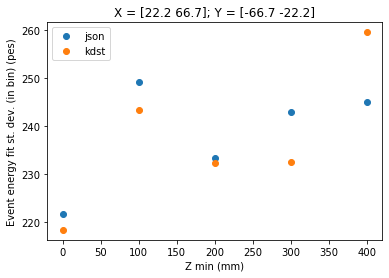

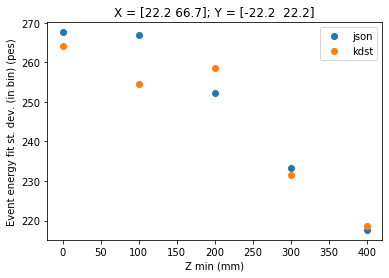

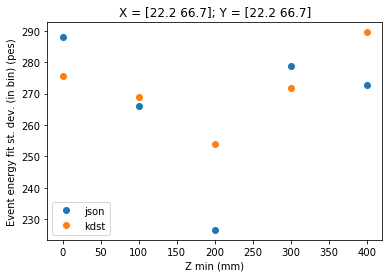

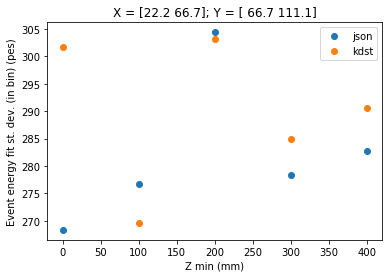

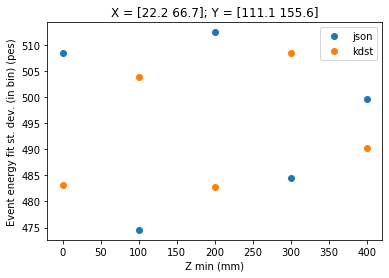

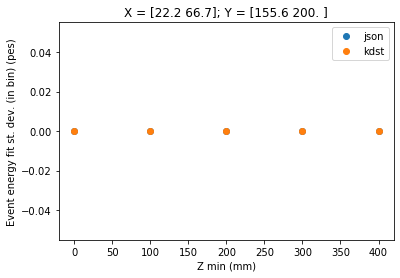

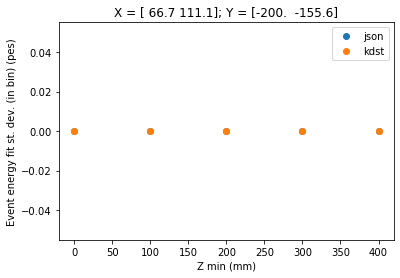

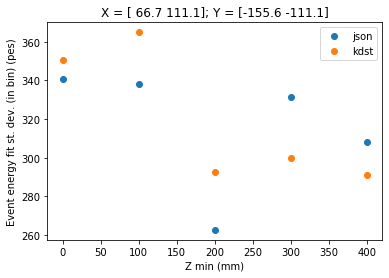

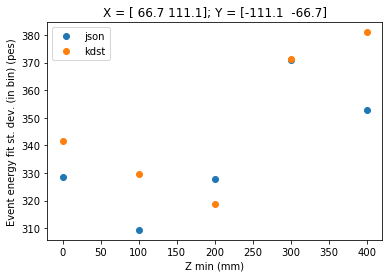

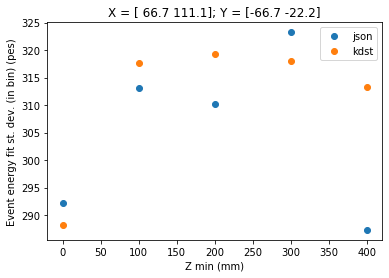

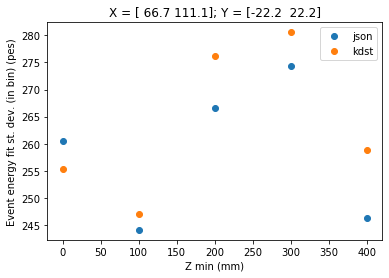

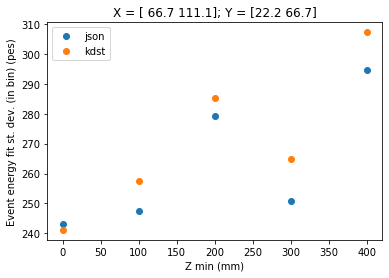

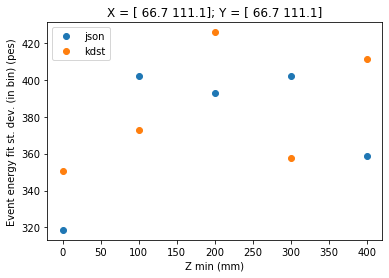

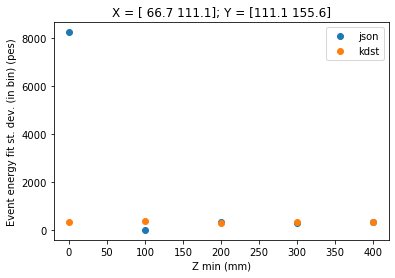

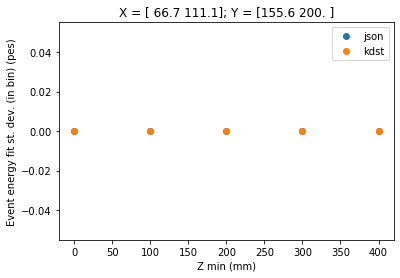

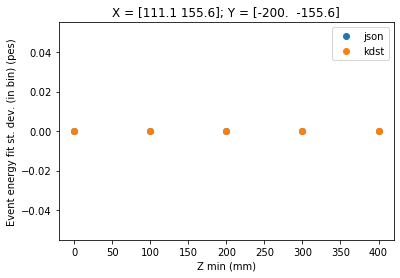

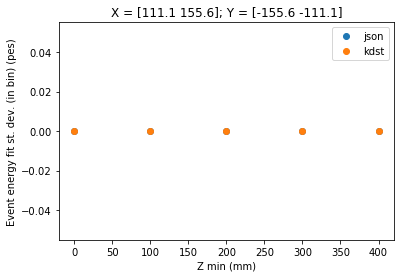

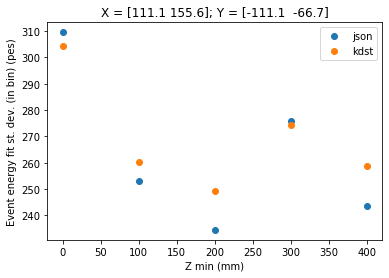

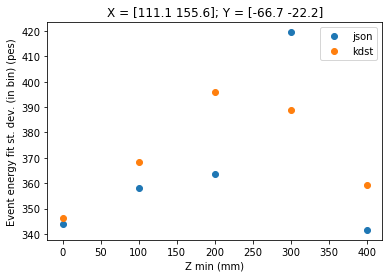

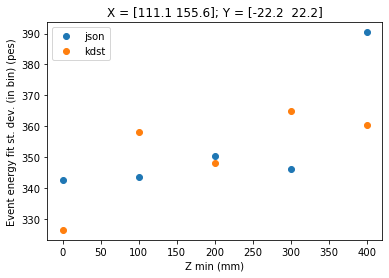

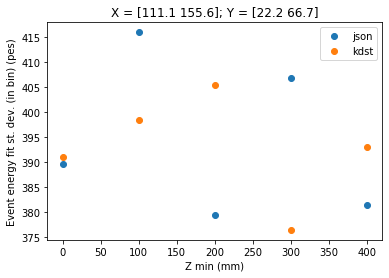

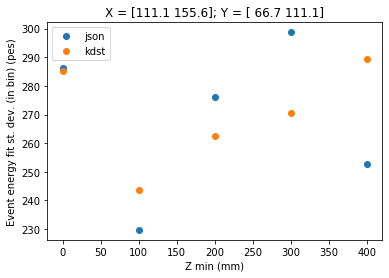

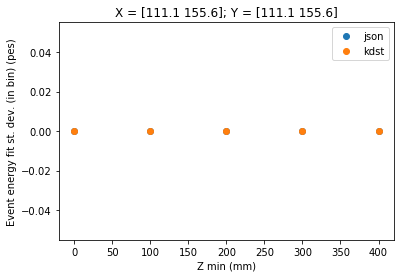

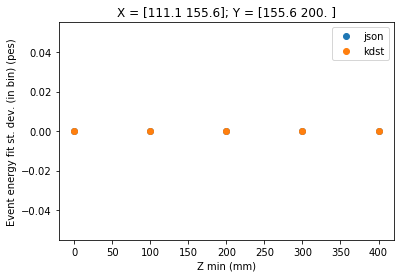

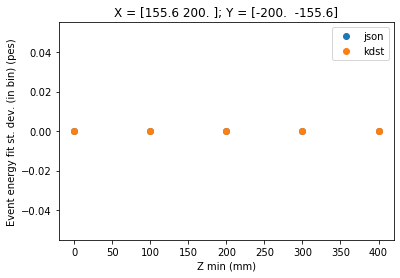

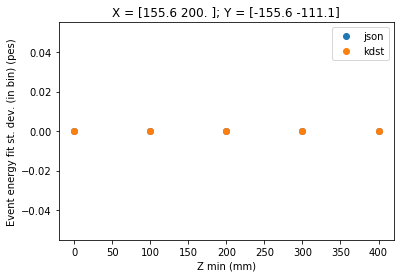

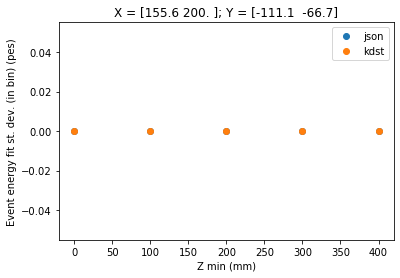

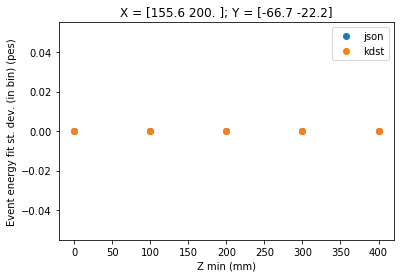

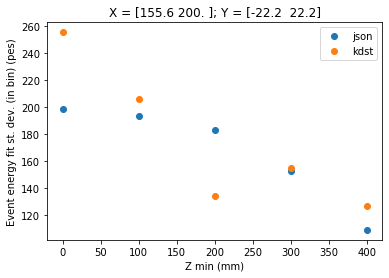

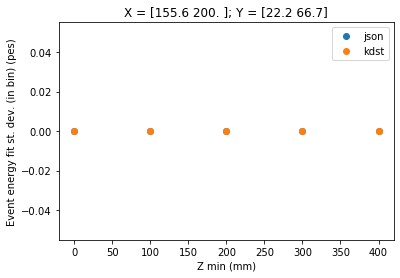

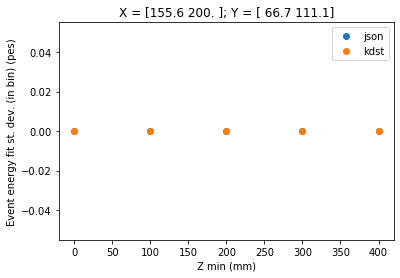

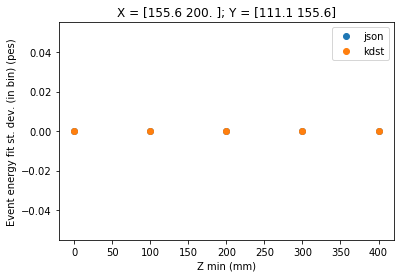

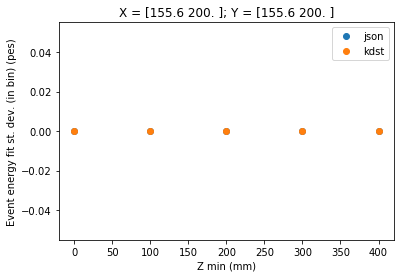

In [23]:
for selX, selY in it.product(range(nxy-1), range(nxy-1)):
    xbinname = str(np.round(xybins[selX],1))
    ybinname = str(np.round(xybins[selY],1))
    plt.plot(zstarts, jbinStds[selX][selY], 'o', label='json')
    plt.plot(zstarts, kbinStds[selX][selY], 'o', label='kdst')
    plt.title('X = '+xbinname+'; Y = '+ybinname)
    plt.xlabel('Z min (mm)')
    plt.ylabel('Event energy fit st. dev. (in bin) (pes)')
    plt.legend()
    plt.show()

In [24]:
printtime()

 Current time = 757.3


/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


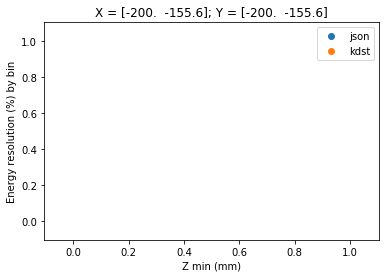

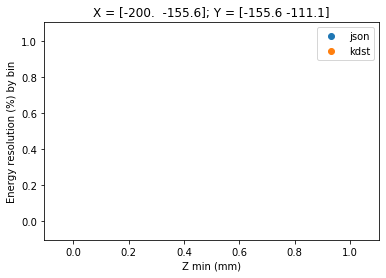

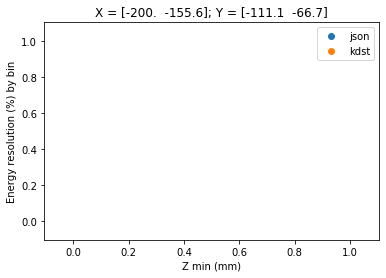

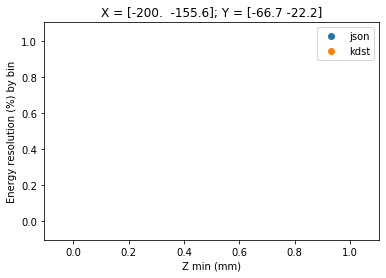

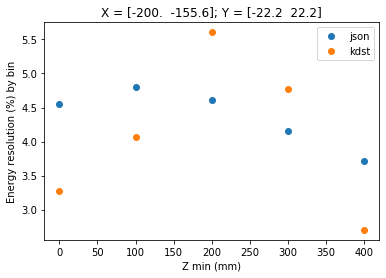

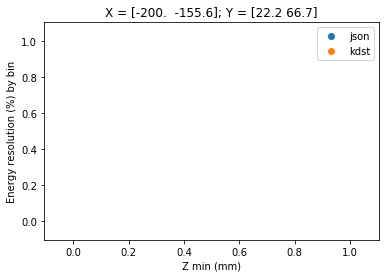

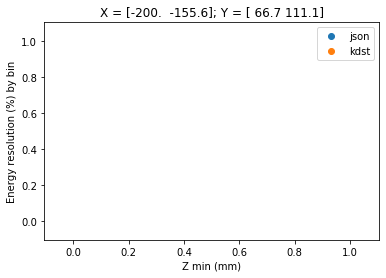

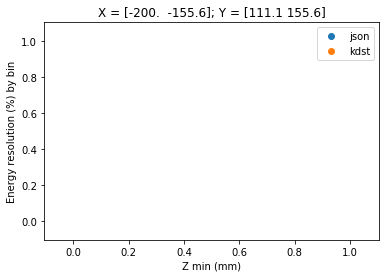

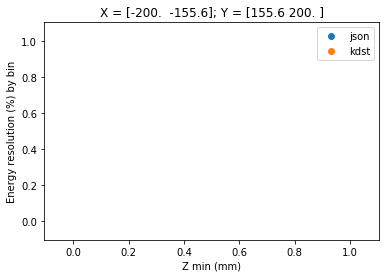

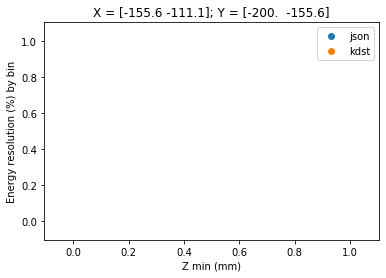

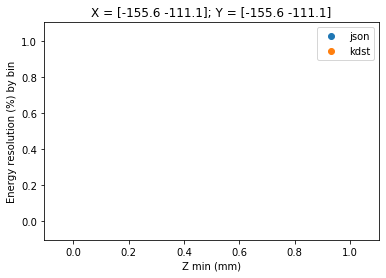

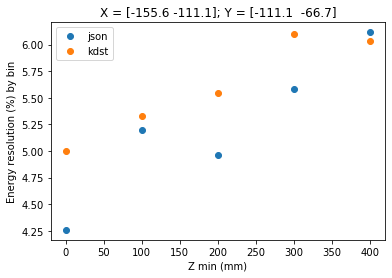

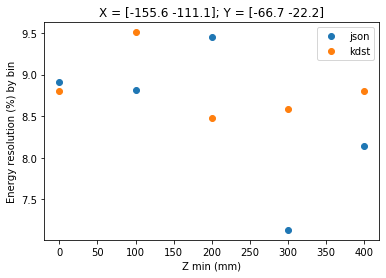

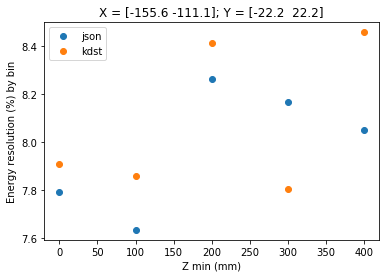

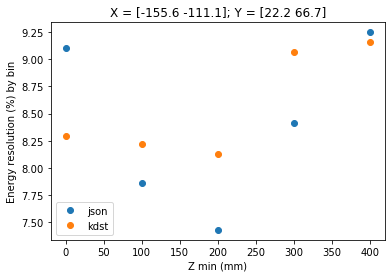

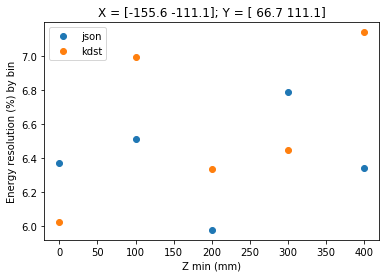

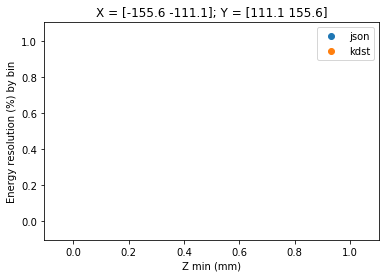

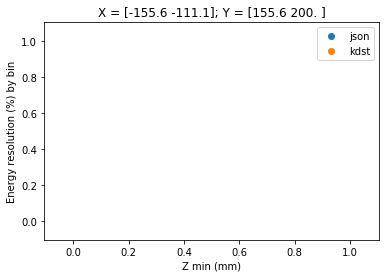

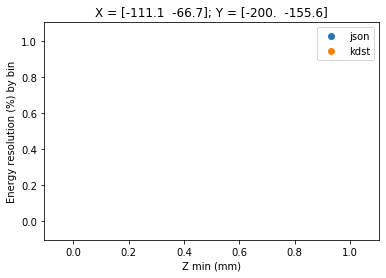

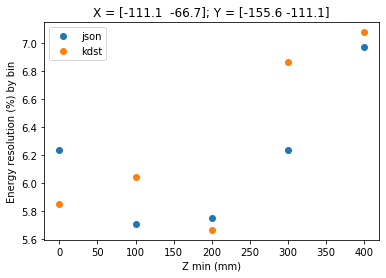

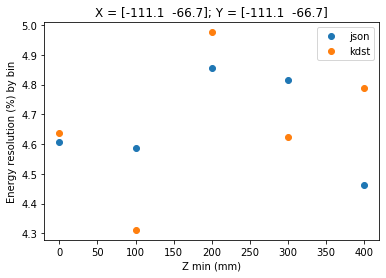

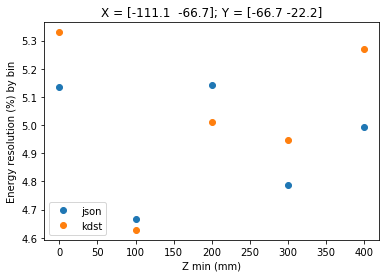

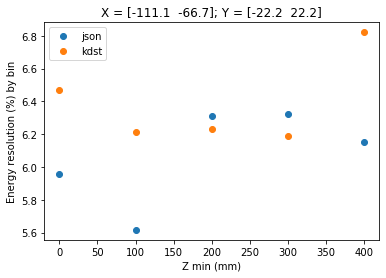

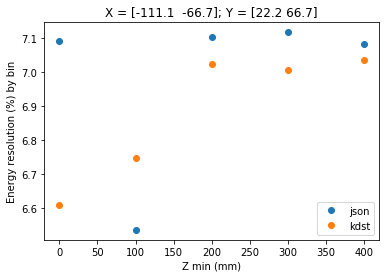

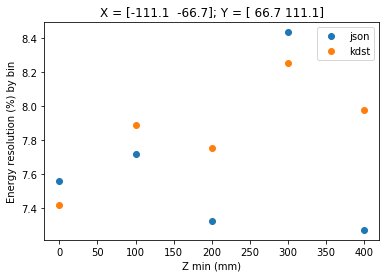

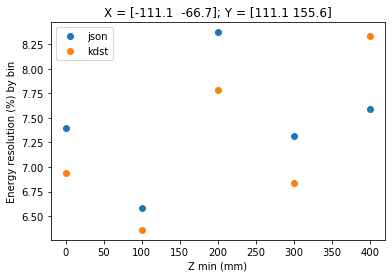

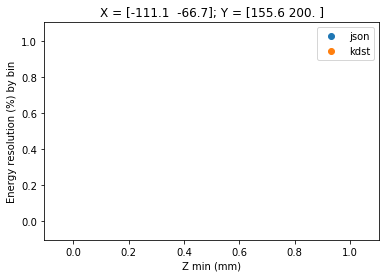

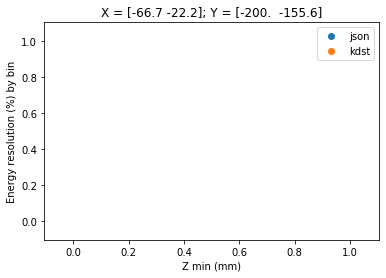

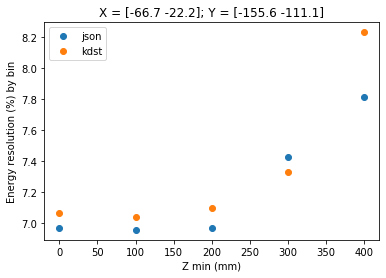

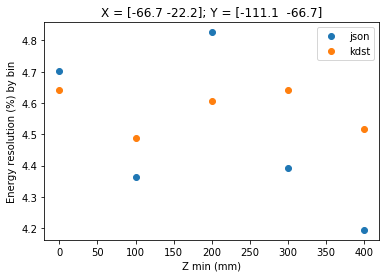

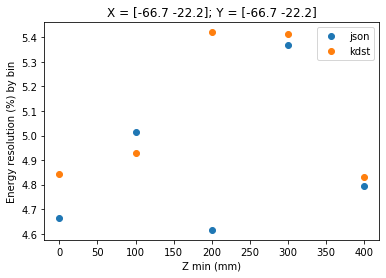

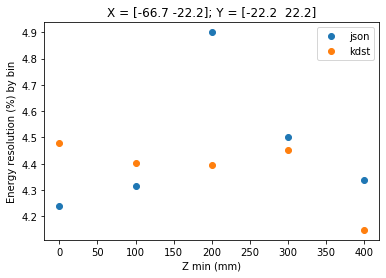

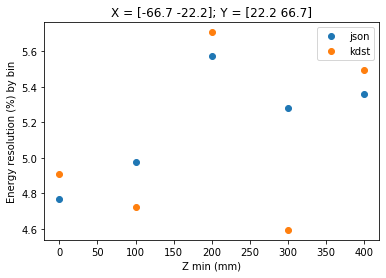

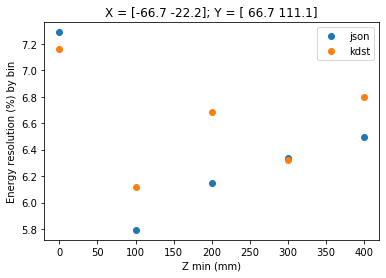

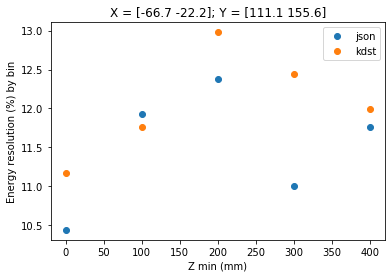

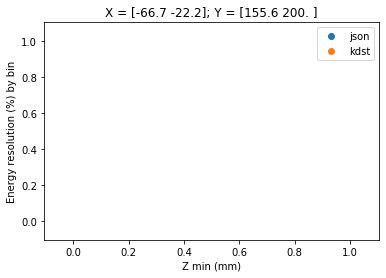

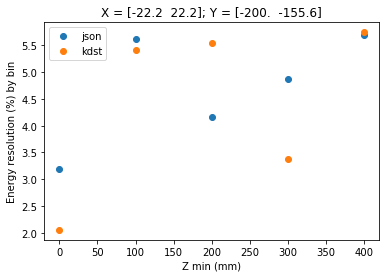

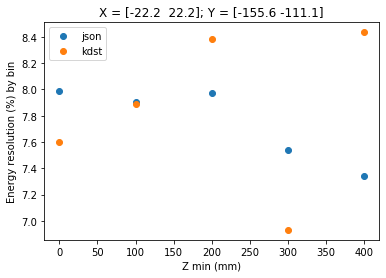

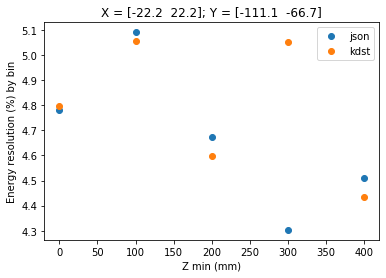

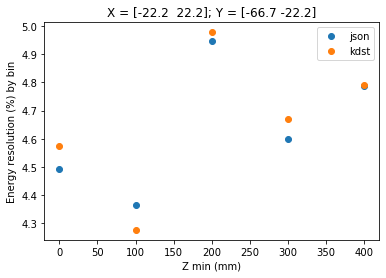

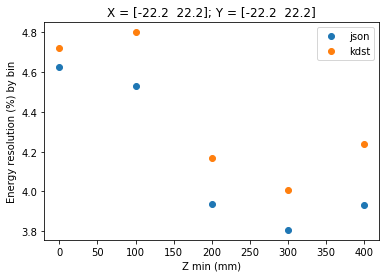

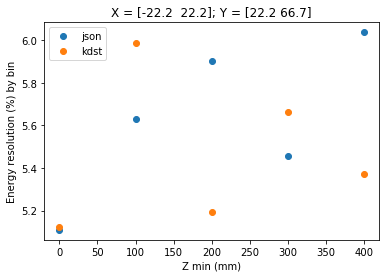

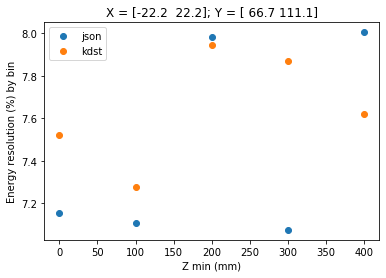

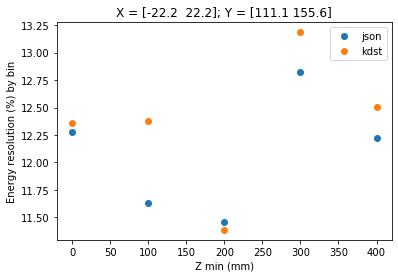

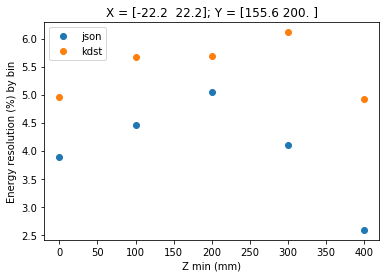

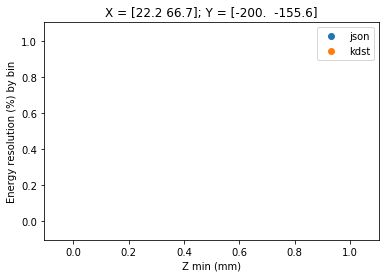

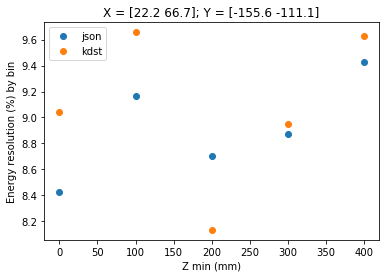

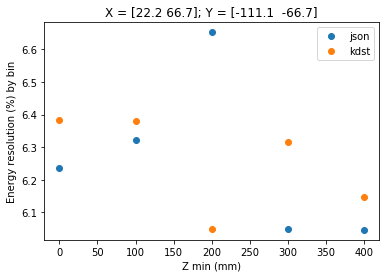

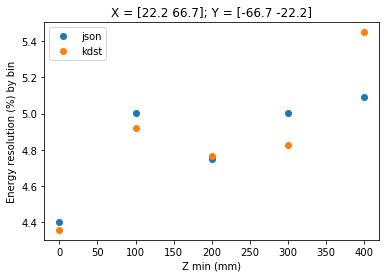

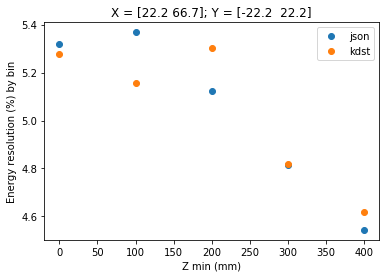

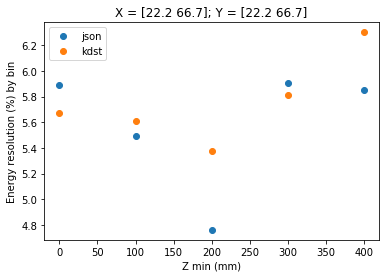

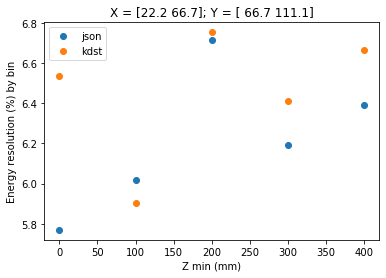

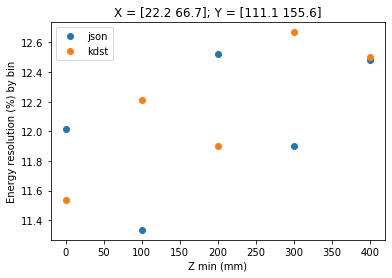

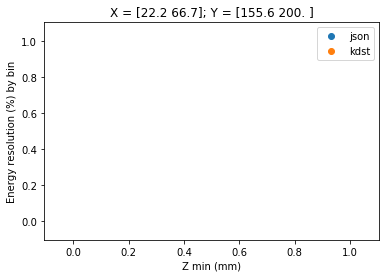

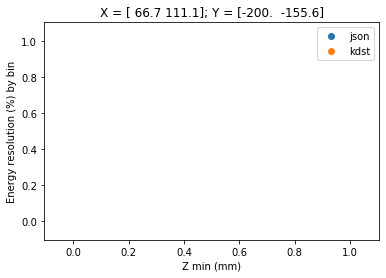

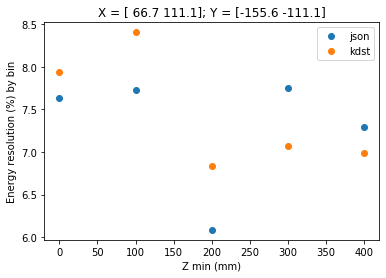

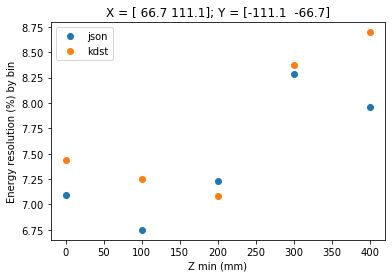

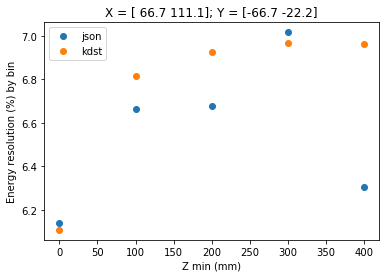

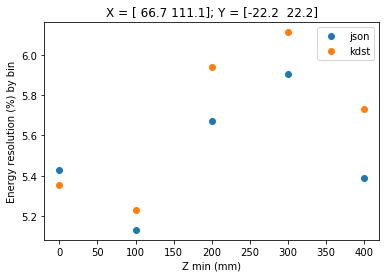

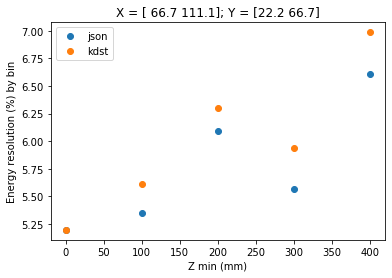

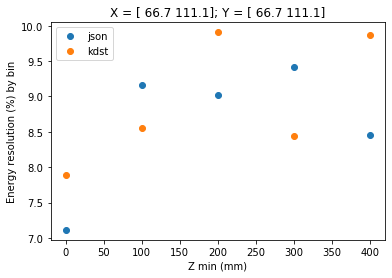

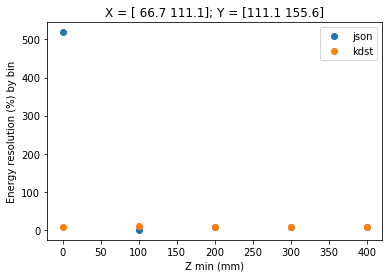

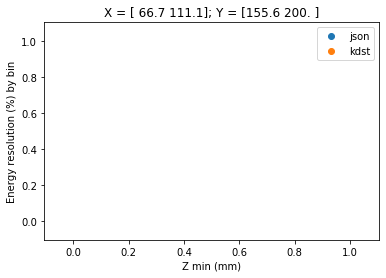

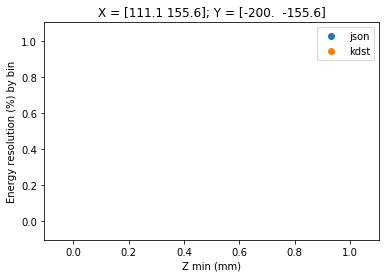

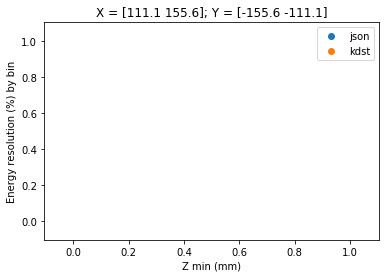

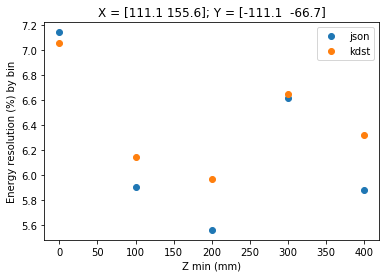

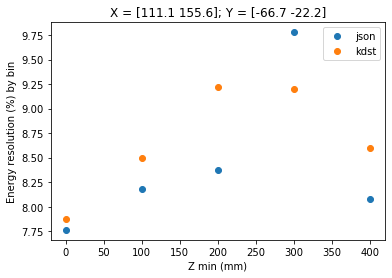

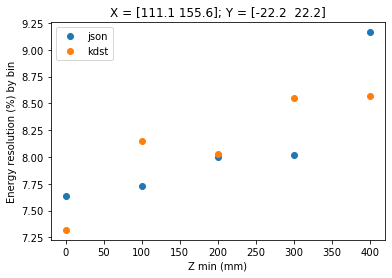

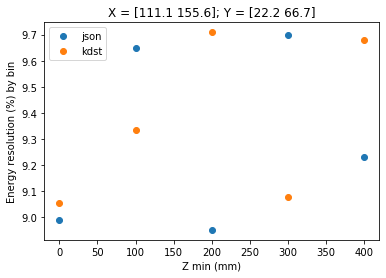

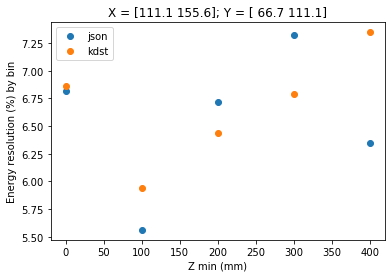

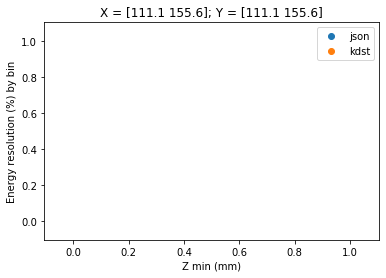

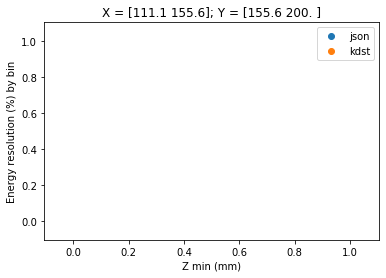

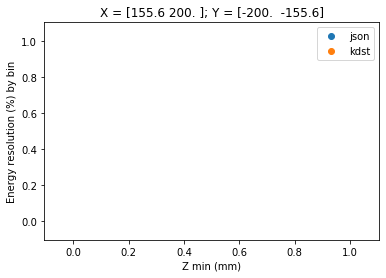

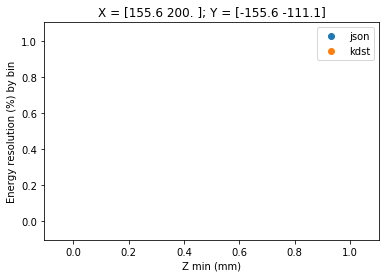

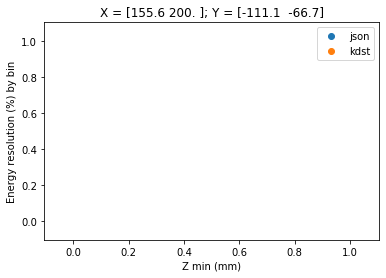

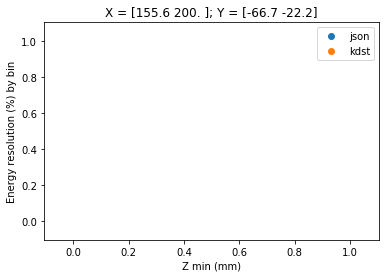

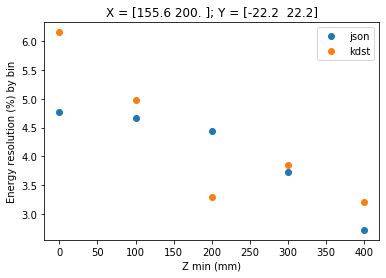

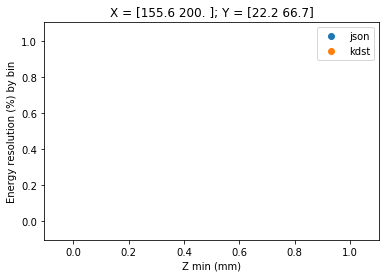

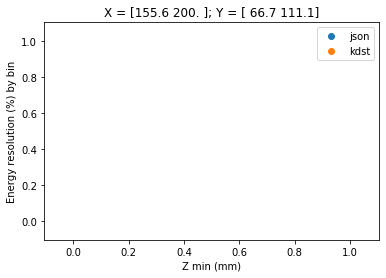

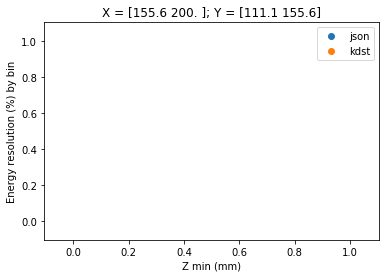

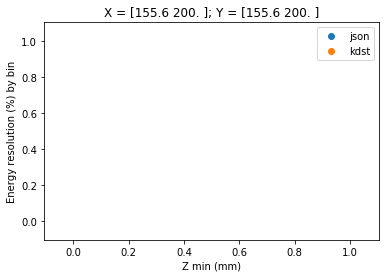

In [25]:
jbinRes = 100 * 2.35 * jbinStds / jbinEs
kbinRes = 100 * 2.35 * kbinStds / kbinEs

for selX, selY in it.product(range(nxy-1), range(nxy-1)):
    xbinname = str(np.round(xybins[selX],1))
    ybinname = str(np.round(xybins[selY],1))
    plt.plot(zstarts, jbinRes[selX][selY], 'o', label='json')
    plt.plot(zstarts, kbinRes[selX][selY], 'o', label='kdst')
    plt.title('X = '+xbinname+'; Y = '+ybinname)
    plt.xlabel('Z min (mm)')
    plt.ylabel('Energy resolution (%) by bin')
    plt.legend()
    plt.show()

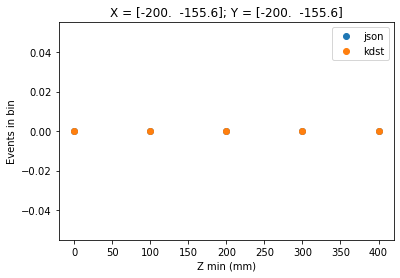

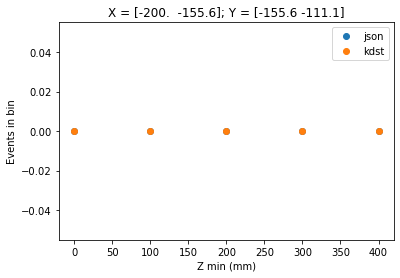

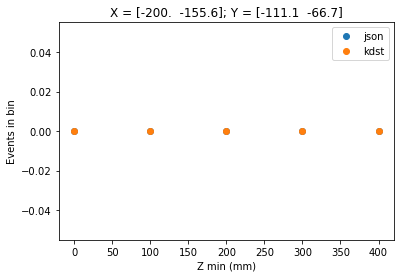

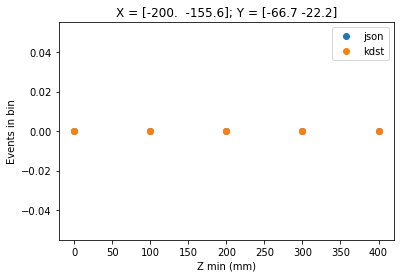

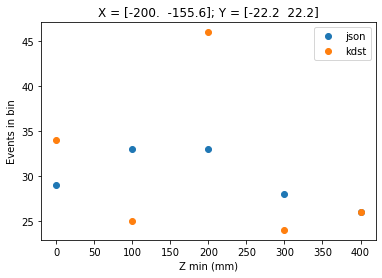

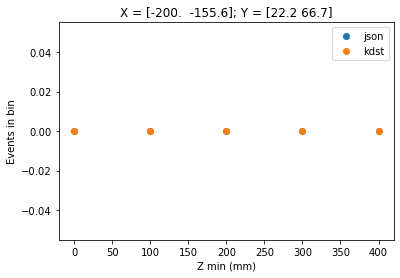

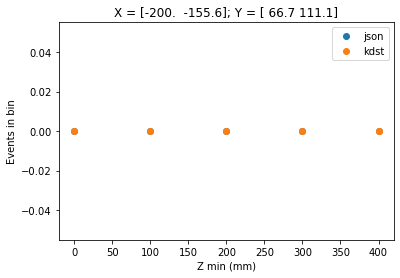

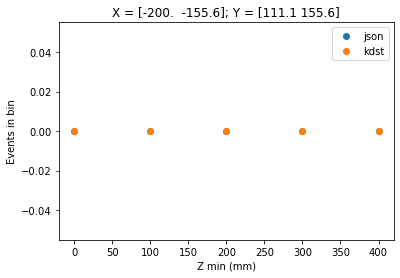

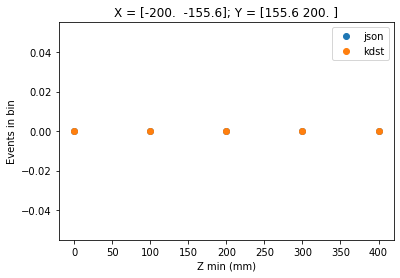

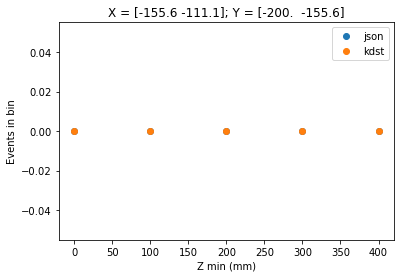

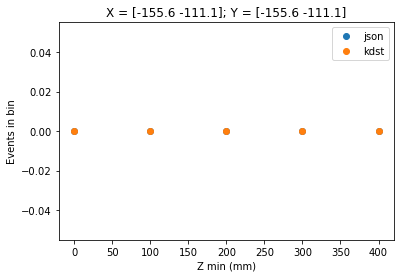

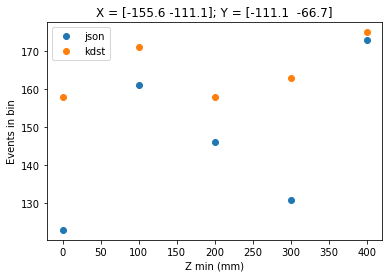

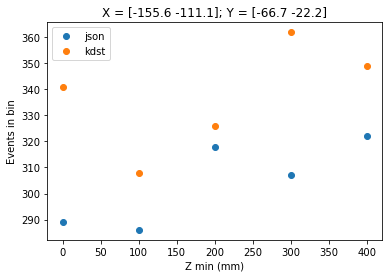

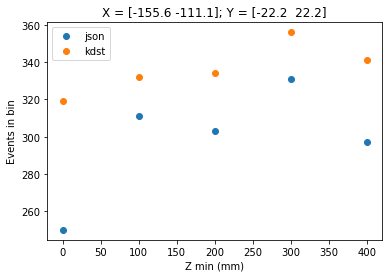

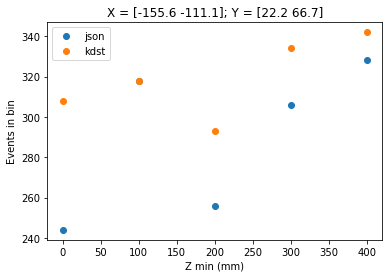

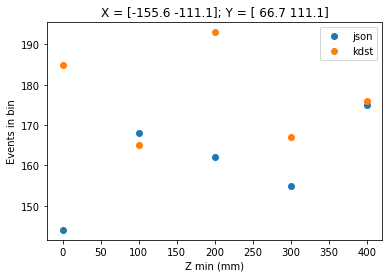

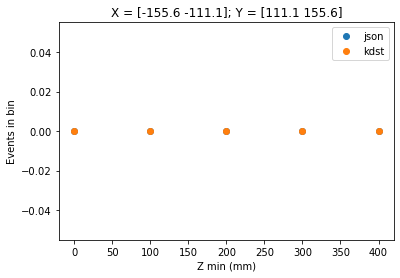

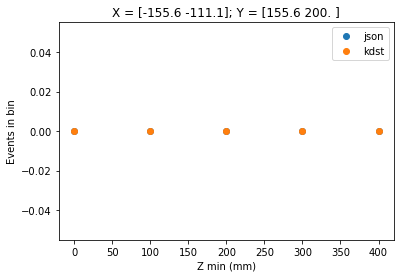

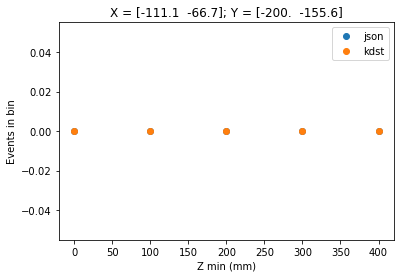

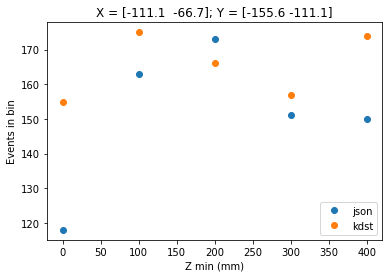

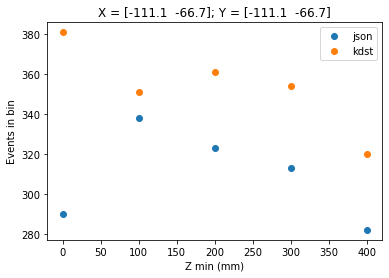

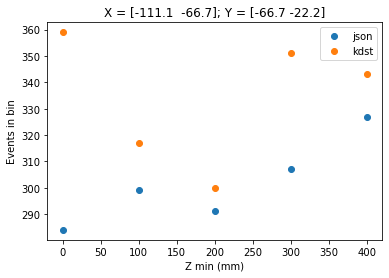

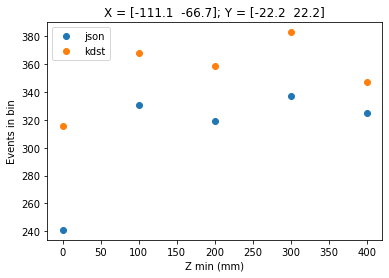

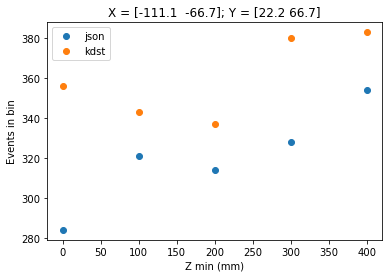

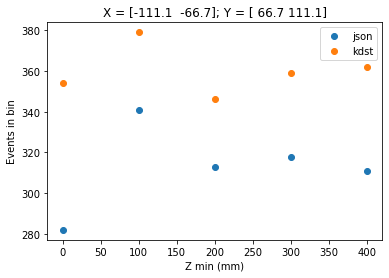

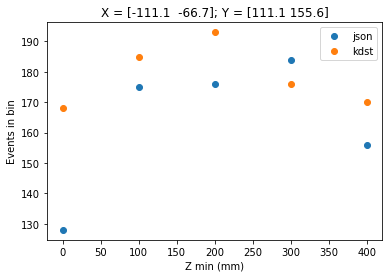

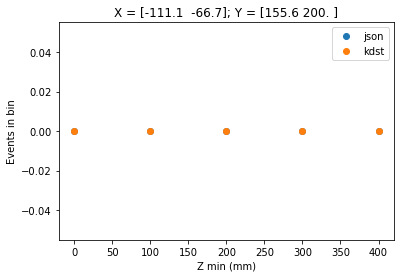

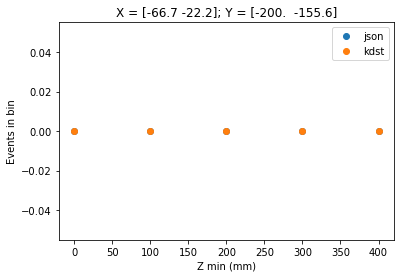

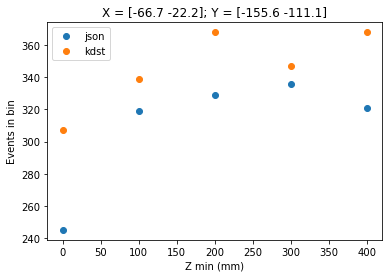

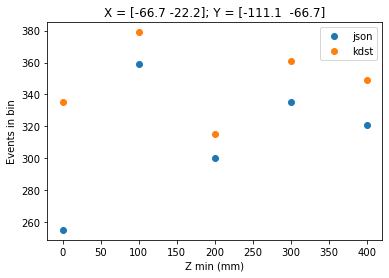

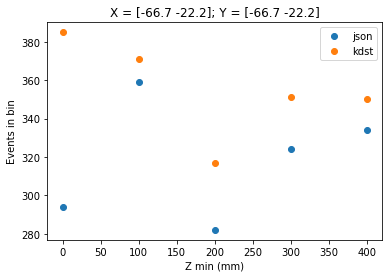

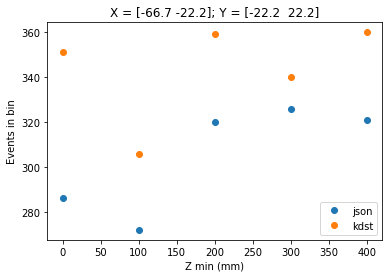

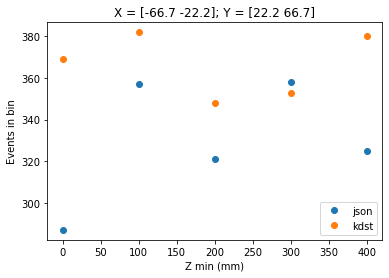

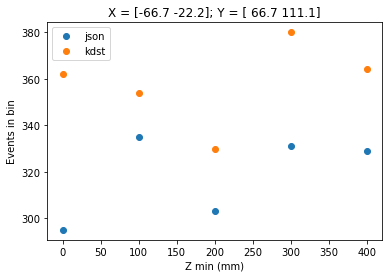

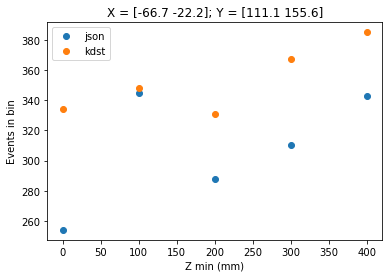

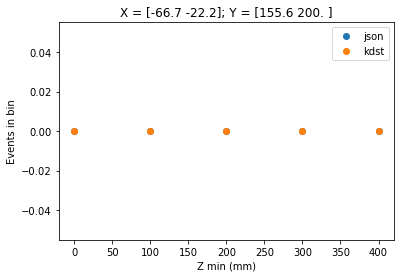

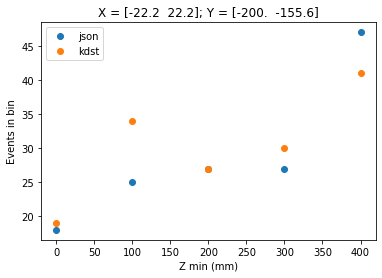

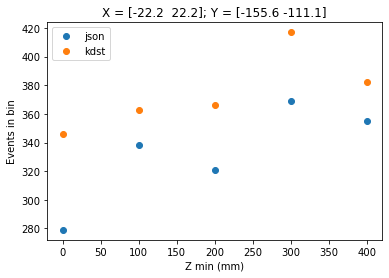

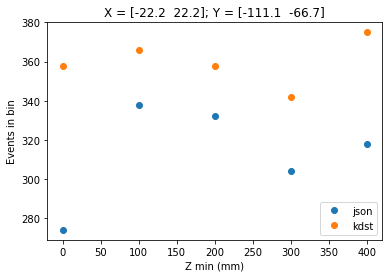

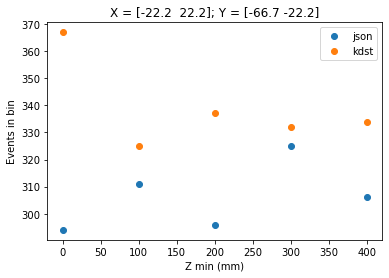

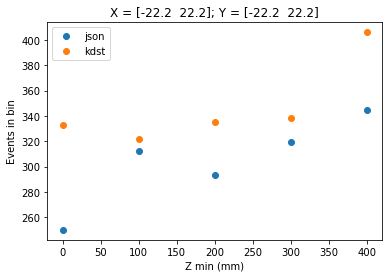

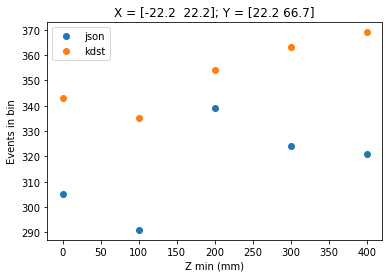

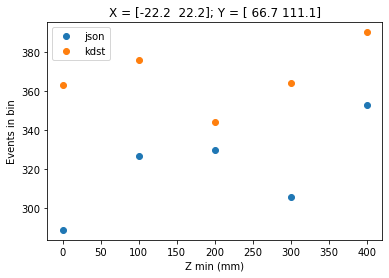

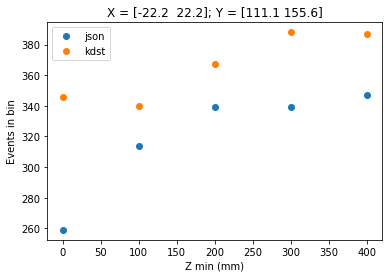

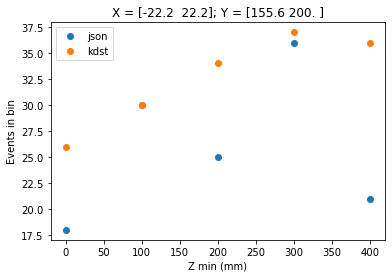

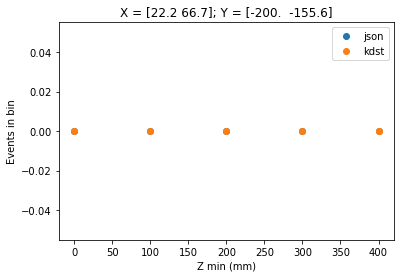

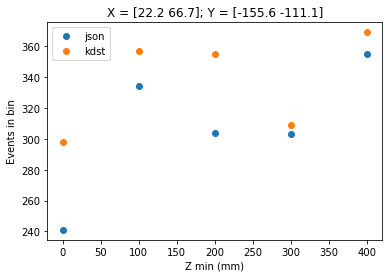

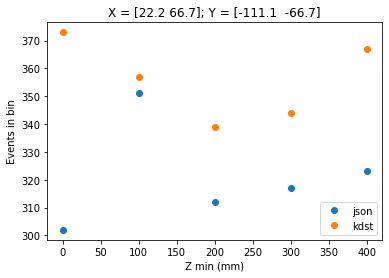

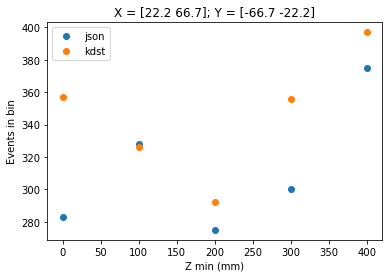

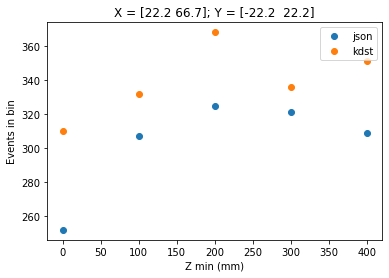

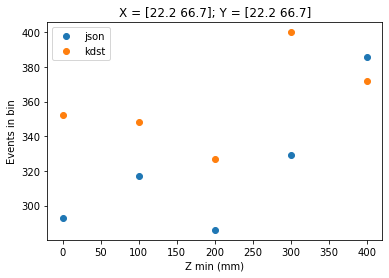

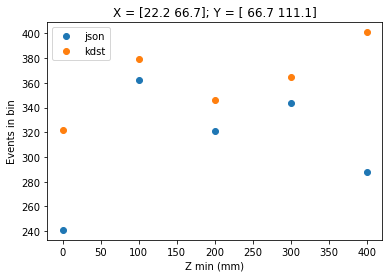

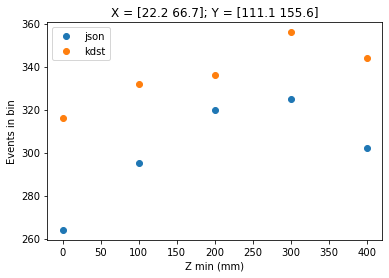

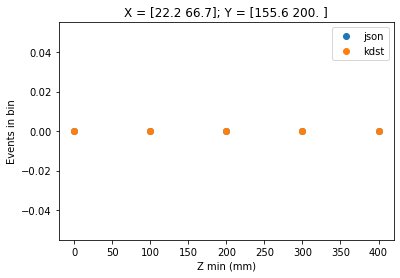

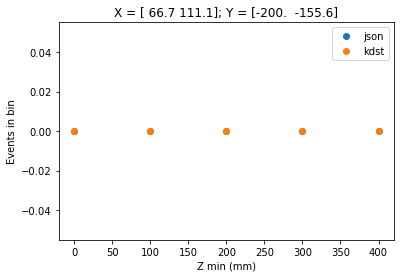

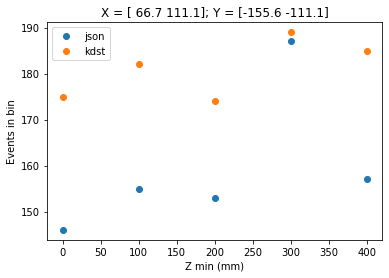

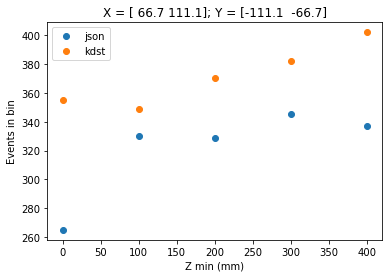

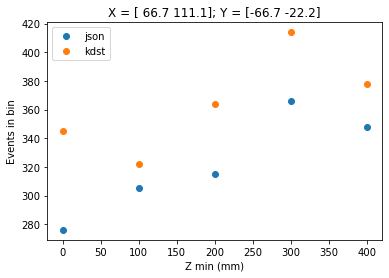

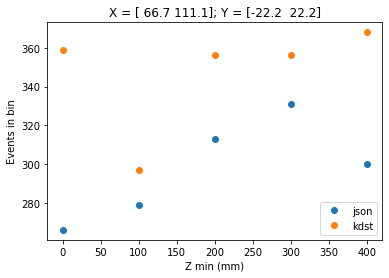

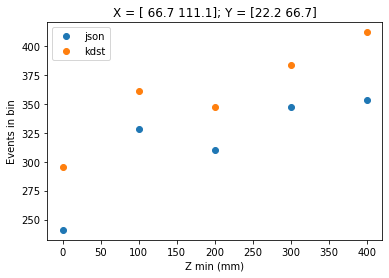

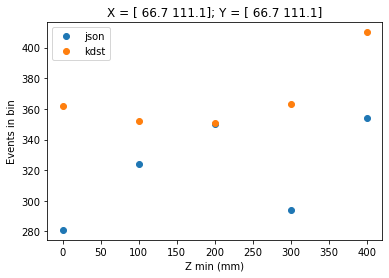

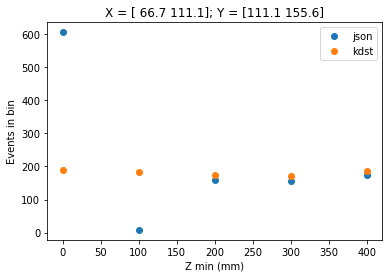

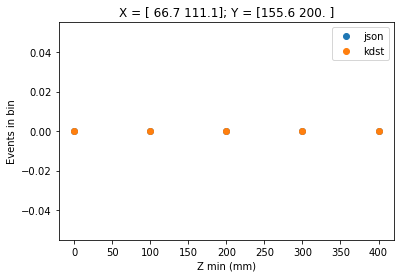

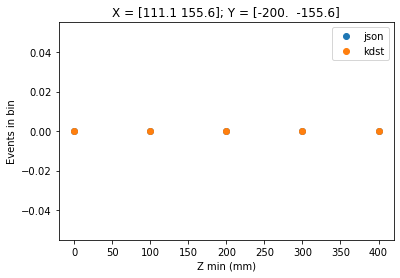

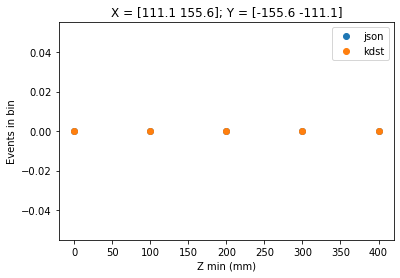

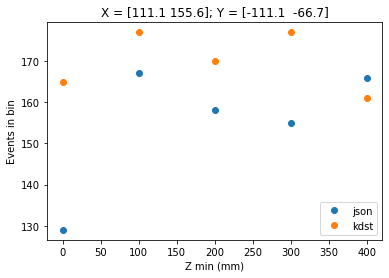

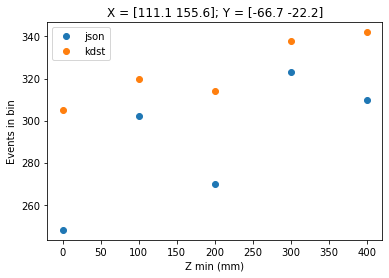

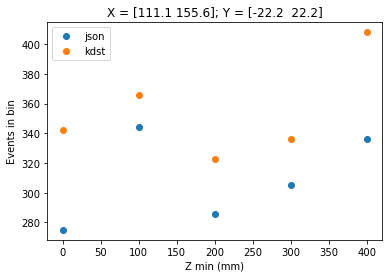

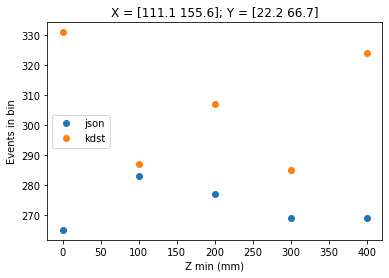

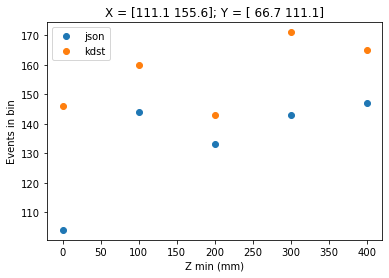

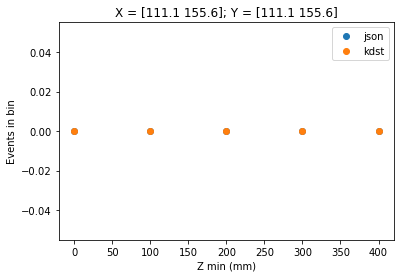

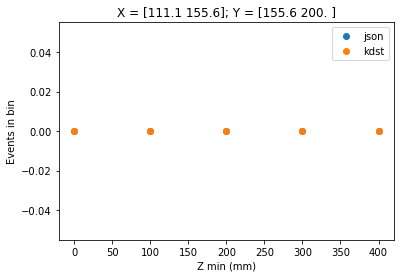

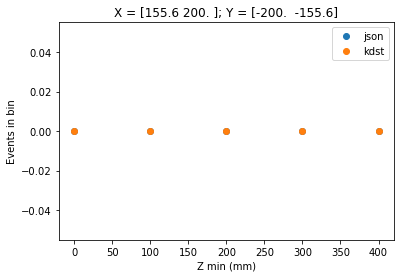

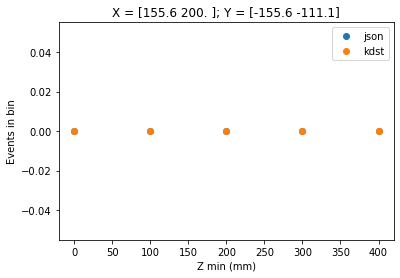

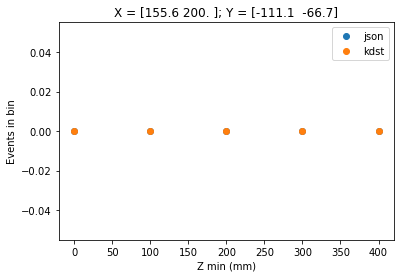

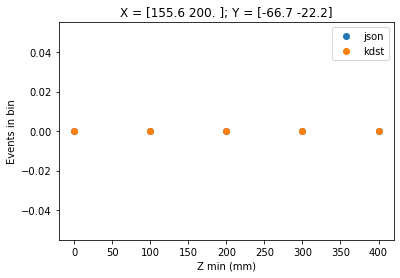

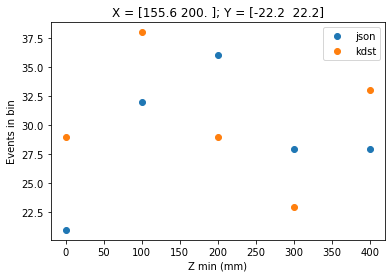

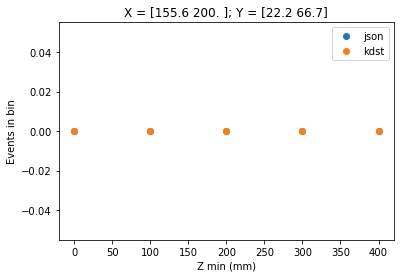

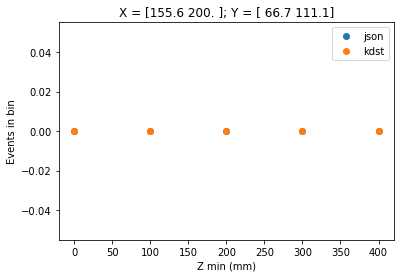

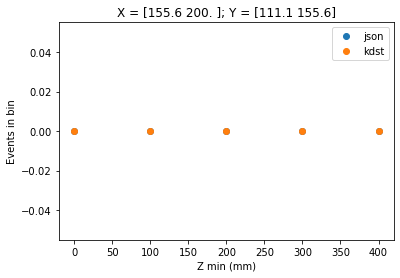

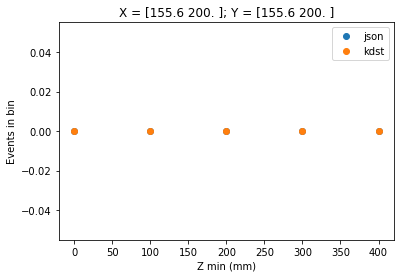

In [26]:
for selX, selY in it.product(range(nxy-1), range(nxy-1)):
    xbinname = str(np.round(xybins[selX],1))
    ybinname = str(np.round(xybins[selY],1))
    plt.plot(zstarts, jbinEvts[selX][selY], 'o', label='json')
    plt.plot(zstarts, kbinEvts[selX][selY], 'o', label='kdst')
    plt.title('X = '+xbinname+'; Y = '+ybinname)
    plt.xlabel('Z min (mm)')
    plt.ylabel('Events in bin')
    plt.legend()
    plt.show()

In [29]:
printtime('Done.', unit='m')

Done. Current time = 20.9
